In [ ]:
# Zhuofan Dong
# zfdong@uchicago.edu

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Codes from duke.py file credit to Adam Duke

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


CVOLSymbols = {
  'clvl': 'WTI Crude Oil CVOL',
  'mvl': 'Metals CVOL',
  'gcvl': 'Gold CVOL',
  'euvl': 'EUR/USD CVOL',
  'cvl': 'Corn CVOL',
  'tyvy': 'US10Y Note Yield CVOL',
  'tyvl': 'US10Y Note Price CVOL',
  'srv': '3M SOFR CVOL'
}


FuturesSymbols = {
  'C': 'Corn Futures',
  'CL': 'WTI Crude Oil Futures',
  'GC': 'Gold Futures',
  'TYF': 'US10Y Note Futures',
}


def examine_timeseries(y, kwargs={}):
  fig, axes = plt.subplots(2,2, figsize=(12,6))
  gs = axes[0,0].get_gridspec()
  for ax in axes[0,:]:
    ax.remove()
  axtop = fig.add_subplot(gs[0,:])
  plot_acf(y, ax=axes[1,0], zero=False, **kwargs.get('acf_kwargs', {}))
  plot_pacf(y, ax=axes[1,1], zero=False, method='ywm', **kwargs.get('pacf_kwargs', {}))
  y.plot(ax=axtop)
  axtop.set_title(kwargs.get('title'))
  fig.tight_layout()
  plt.show()


def forward_price_gap(dataframe,horizon,quantile):
    '''
    Expects a dataframe indexed by symbol and descending date
    '''
    return dataframe\
        .reset_index()\
        .groupby('symbol')\
        .rolling(pd.Timedelta(days=horizon), on='date')\
        .quantile(quantile)\
        .set_index('date', append=True)\
        .droplevel(1)\
        .set_axis([f'{horizon}DFPG_q{int(100*quantile)}'], axis=1)


def z_quantile(z):
   return 2*scipy.stats.norm.cdf(z)-1


def get_response(df, nDays, zLevel):
   assert(nDays in [7,15,30,45])
   assert(zLevel in [1,2,3])
   return zLevel*df['cvol'] - df[f'{nDays}DFPG_q{int(100*(z_quantile(zLevel)))}']


def get_moments(x):
  return {
    'mean': np.mean(x),
    'sdev': np.std(x),
    'skew': scipy.stats.skew(x),
    'kurt': scipy.stats.kurtosis(x)
  }


In [ ]:
#from prince import FAMD
# famd = FAMD(n_components=40, random_state=123)
# X_new = famd.fit_transform(X)
# X_new

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from functools import partial
from matplotlib.pyplot import cm
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    auc)
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  dataRoot = '/content/drive/Shareddrives/MSCA Capstone Project/Data'
else:
  dataRoot = os.path.join(os.getcwd(), 'data')

Mounted at /content/drive


In [ ]:
data = pd.read_parquet(f'{dataRoot}/features_with_events.parquet')
response = pd.read_parquet(f'{dataRoot}/response.parquet')

In [ ]:
rmse = partial(mse, squared=False)

tround = lambda x,threshold: np.round(x - threshold + 0.5)

def fscore(p,r):
  z = (p+r) == 0
  r[z] = np.nan
  p[z] = np.nan
  return (2*p*r)/(p+r)

def foo(vRecall,vPrecision,response,prediction):
  fig,axes = plt.subplots(1, 2, figsize=(12,6))
  ax = axes[0]
  ax.plot(vRecall, vPrecision)
  ax.set_xlabel('recall')
  ax.set_ylabel('precision')
  ax.set_title('PR Curve')
  ax = axes[1]
  ConfusionMatrixDisplay(confusion_matrix(response, prediction, normalize='all')).plot(ax=ax)
  fig.tight_layout()
  plt.show()
  print(classification_report(response, prediction))

In [ ]:
data.head()

volume  openInterest      skew  skewRatio  convexity       HML  \
0  0.310414      0.704079  0.000104     1.0084     1.0661  0.021412   
1  0.211286      0.701986 -0.000074     0.9936     1.0532  0.013667   
2  0.185492      0.703200  0.000137     1.0123     1.0597  0.012750   
3  0.154063      0.699358  0.000364     1.0347     1.0423  0.011282   
4  0.283246      0.697278  0.000290     1.0261     1.0564  0.017809   

        Date  Optimal Blue Mortgage Market Indices  Penn World Table 10.0  \
0 2013-10-01                                   0.0                    0.0   
1 2013-10-02                                   0.0                    0.0   
2 2013-10-03                                   0.0                    0.0   
3 2013-10-04                                   0.0                    0.0   
4 2013-10-07                                   0.0                    0.0   

   ICE BofA Indices  ...  Quarterly National Accounts  Job Postings on Indeed  \
0               0.0  ...                          1.0                     0.0   
1               0.0  ...                          0.0                     0.0   
2               0.0  ...                          0.0                     0.0   
3               0.0  ...                          0.0                     0.0   
4               0.0  ...                          0.0                     0.0   

   New Patent Assignments  Construction Spending  Penn World Table 10.01  \
0                     0.0                    0.0                     0.0   
1                     0.0                    0.0                     0.0   
2                     0.0                    0.0                     0.0   
3                     0.0                    0.0                     0.0   
4                     0.0                    0.0                     0.0   

   Weekly National Rates and Rate Caps  gap_1  gap_2  gap_3  gap_4  
0                                  0.0      1      0      0      0  
1                                  0.0      1      0      0      0  
2                                  0.0      1      0      0      0  
3                                  0.0      1      0      0      0  
4                                  0.0      0      0      1      0  

[5 rows x 51 columns]

In [ ]:
response.head()

cvol  15DFPG_q95  15DFPG_q99  15DFPG_q100  30DFPG_q68  \
date                                                                    
2013-10-01  0.012476    0.015947    0.017135      0.01721    0.010480   
2013-10-02  0.011557    0.015947    0.017135      0.01721    0.010480   
2013-10-03  0.011193    0.015947    0.017135      0.01721    0.010480   
2013-10-04  0.010685    0.015947    0.017135      0.01721    0.010988   
2013-10-07  0.011253    0.015947    0.017135      0.01721    0.010480   

            30DFPG_q95  30DFPG_q99  30DFPG_q100  45DFPG_q68  45DFPG_q95  \
date                                                                      
2013-10-01    0.017416    0.021568      0.02183    0.009025    0.017862   
2013-10-02    0.017416    0.021568      0.02183    0.009800    0.017862   
2013-10-03    0.017416    0.021568      0.02183    0.010021    0.017916   
2013-10-04    0.017626    0.021581      0.02183    0.010175    0.017971   
2013-10-07    0.017416    0.021568      0.02183    0.011370    0.020269   

            45DFPG_q99  45DFPG_q100       Date         y  
date                                                      
2013-10-01    0.021534     0.021830 2013-10-01  0.009006  
2013-10-02    0.021534     0.021830 2013-10-02  0.007166  
2013-10-03    0.021544     0.021830 2013-10-03  0.006439  
2013-10-04    0.021553     0.021830 2013-10-04  0.005422  
2013-10-07    0.024061     0.024272 2013-10-07  0.006558

Data Cleaning

In [ ]:
response['y'] = get_response(response, 15, 2)
response1 = response.loc[:, ['Date', 'y']]

In [ ]:
df_X = pd.merge(response1, data, on = "Date", how = "right")
df_X = df_X.dropna()
df_X

y = (df_X['y'] > 0).map({False: 0, True: 1})

In [ ]:
X = df_X.drop(['Date', 'y'], axis=1)

In [ ]:
X

volume  openInterest      skew  skewRatio  convexity       HML  \
0     0.310414      0.704079  0.000104     1.0084     1.0661  0.021412   
1     0.211286      0.701986 -0.000074     0.9936     1.0532  0.013667   
2     0.185492      0.703200  0.000137     1.0123     1.0597  0.012750   
3     0.154063      0.699358  0.000364     1.0347     1.0423  0.011282   
4     0.283246      0.697278  0.000290     1.0261     1.0564  0.017809   
...        ...           ...       ...        ...        ...       ...   
2389  0.299119      0.409263  0.000463     1.0377     1.1035  0.015068   
2390  0.228092      0.399963  0.000519     1.0405     1.1061  0.010163   
2391  0.385401      0.387554  0.000650     1.0595     1.1193  0.026045   
2392  0.293730      0.380935  0.000166     1.0151     1.1029  0.018856   
2393  0.267449      0.369476  0.000197     1.0181     1.1158  0.013770   

      Optimal Blue Mortgage Market Indices  Penn World Table 10.0  \
0                                      0.0                    0.0   
1                                      0.0                    0.0   
2                                      0.0                    0.0   
3                                      0.0                    0.0   
4                                      0.0                    0.0   
...                                    ...                    ...   
2389                                   1.0                    0.0   
2390                                   1.0                    0.0   
2391                                   1.0                    0.0   
2392                                   1.0                    0.0   
2393                                   1.0                    0.0   

      ICE BofA Indices  Survey of Business Uncertainty  ...  \
0                  0.0                             0.0  ...   
1                  0.0                             0.0  ...   
2                  0.0                             0.0  ...   
3                  0.0                             0.0  ...   
4                  0.0                             0.0  ...   
...                ...                             ...  ...   
2389               1.0                             1.0  ...   
2390               1.0                             0.0  ...   
2391               1.0                             0.0  ...   
2392               1.0                             0.0  ...   
2393               1.0                             0.0  ...   

      Quarterly National Accounts  Job Postings on Indeed  \
0                             1.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
...                           ...                     ...   
2389                          0.0                     0.0   
2390                          0.0                     0.0   
2391                          0.0                     0.0   
2392                          1.0                     0.0   
2393                          0.0                     0.0   

      New Patent Assignments  Construction Spending  Penn World Table 10.01  \
0                        0.0                    0.0                     0.0   
1                        0.0                    0.0                     0.0   
2                        0.0                    0.0                     0.0   
3                        0.0                    0.0                     0.0   
4                        0.0                    0.0                     0.0   
...                      ...                    ...                     ...   
2389                     0.0                    0.0                     0.0   
2390                     0.0                    0.0                     0.0   
2391                     0.0                    0.0                     0.0   
2392      

Feature Selection

In [ ]:
import itertools
list_set = [['volume', 'openInterest'], ['skew', 'skewRatio']]
comb_set = []
for element in itertools.product(*list_set):
  comb_set.append(list(element))

In [ ]:
X1 = X.drop(columns=comb_set[0], axis=1)
X2 = X.drop(columns=comb_set[1], axis=1)
X3 = X.drop(columns=comb_set[2], axis=1)
X4 = X.drop(columns=comb_set[3], axis=1)

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Traditional Machine Learning

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression().fit(X_train, y_train)
model.score(X_test,y_test)

0.6722338204592901

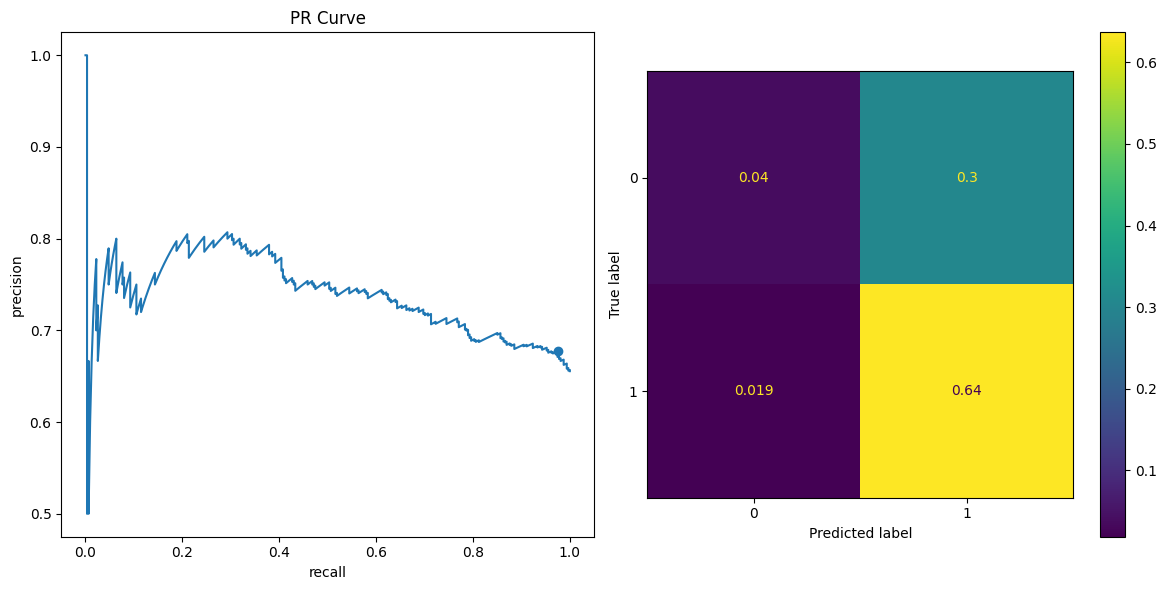

              precision    recall  f1-score   support

           0       0.68      0.12      0.20       165
           1       0.68      0.97      0.80       314

    accuracy                           0.68       479
   macro avg       0.68      0.54      0.50       479
weighted avg       0.68      0.68      0.59       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

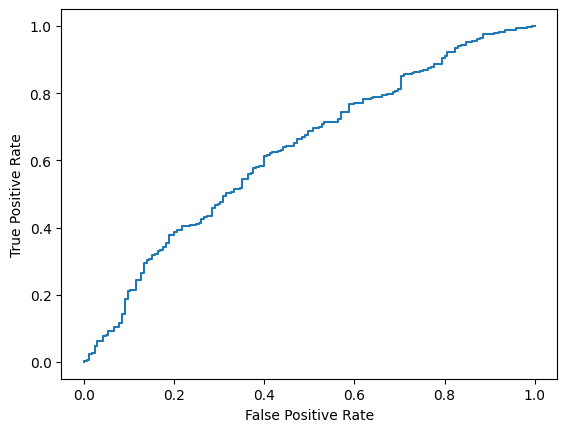

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
model.score(X_test,y_test)

0.6555323590814196

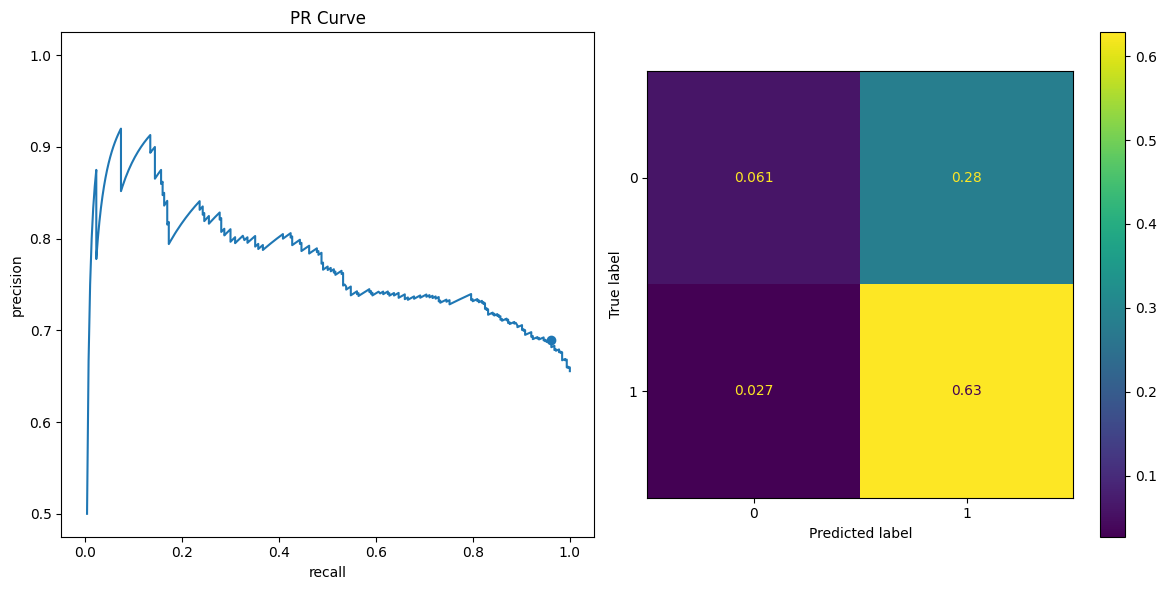

              precision    recall  f1-score   support

           0       0.69      0.18      0.28       165
           1       0.69      0.96      0.80       314

    accuracy                           0.69       479
   macro avg       0.69      0.57      0.54       479
weighted avg       0.69      0.69      0.62       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

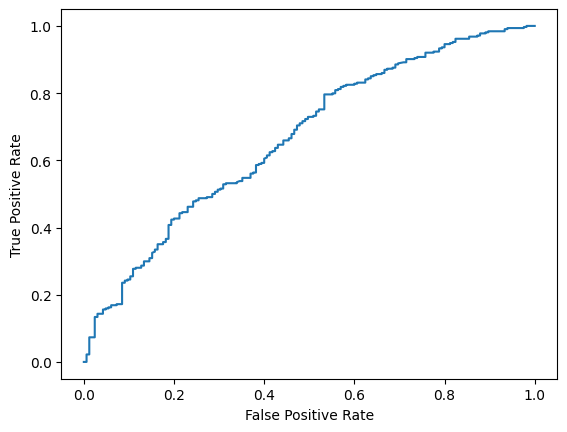

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train,y_train)
model.score(X_test,y_test)

0.7620041753653445

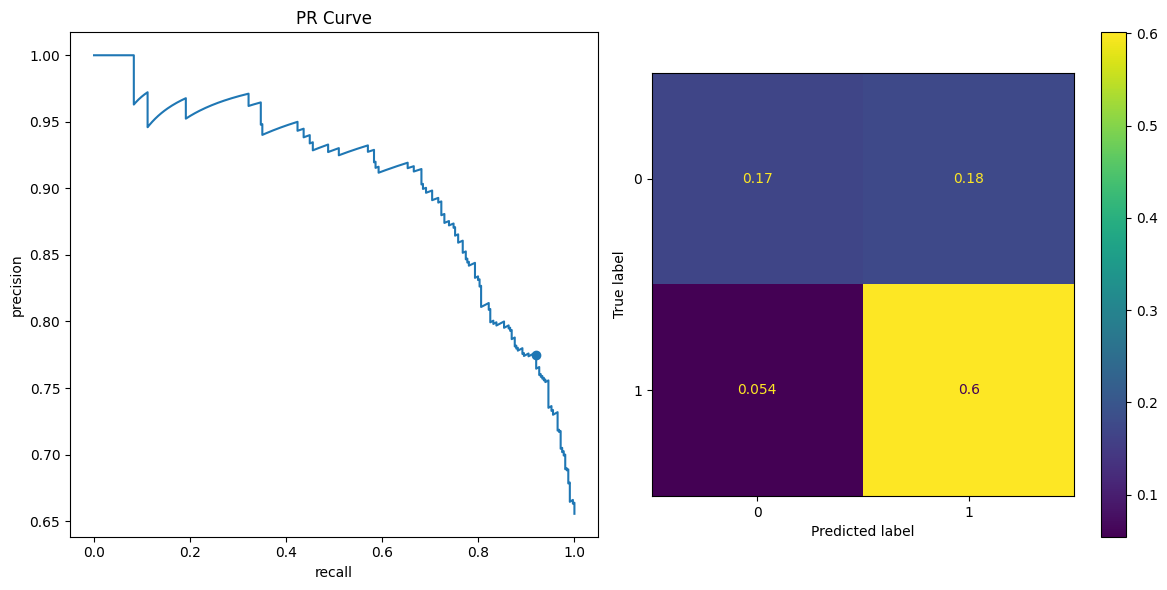

              precision    recall  f1-score   support

           0       0.76      0.49      0.60       165
           1       0.77      0.92      0.84       314

    accuracy                           0.77       479
   macro avg       0.77      0.70      0.72       479
weighted avg       0.77      0.77      0.76       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

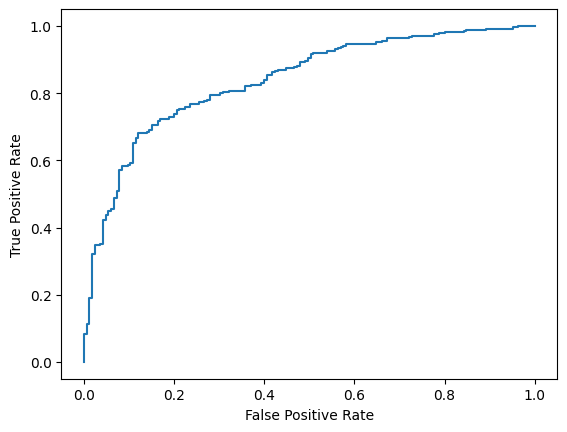

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

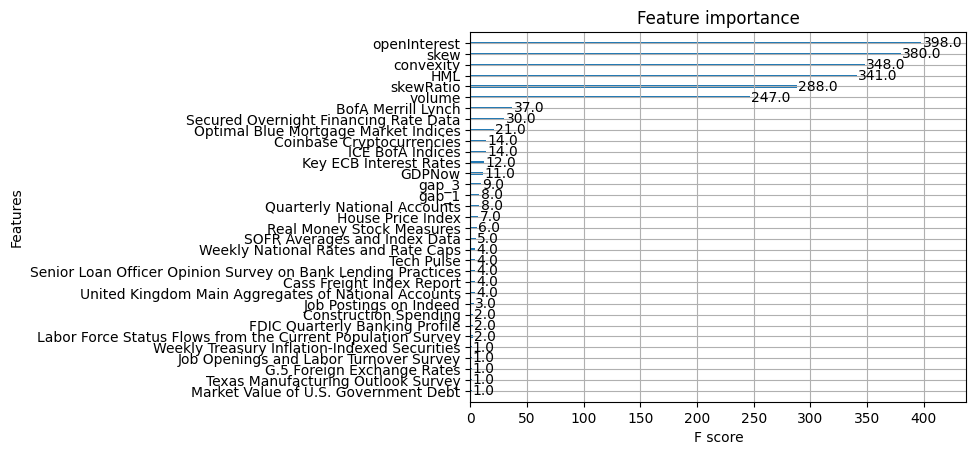

In [ ]:
xgb.plot_importance(model)

Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Linear Kernel
model = SVC(gamma='auto', kernel='linear', probability=True).fit(X_train, y_train)
model.score(X_test,y_test)

0.6492693110647182

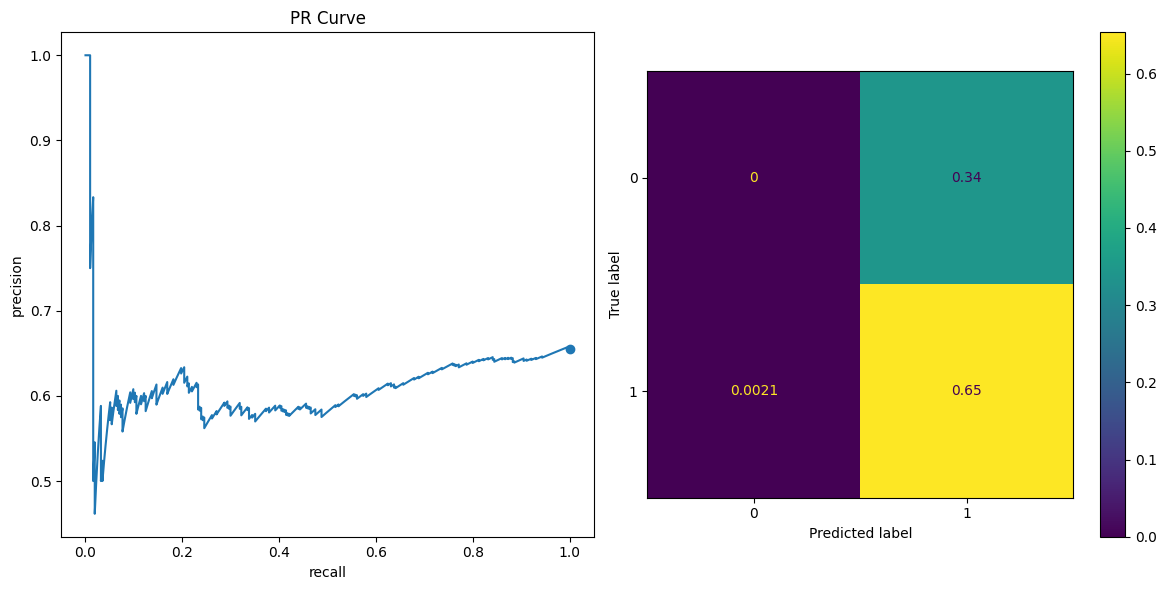

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.65      1.00      0.79       314

    accuracy                           0.65       479
   macro avg       0.33      0.50      0.40       479
weighted avg       0.43      0.65      0.52       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

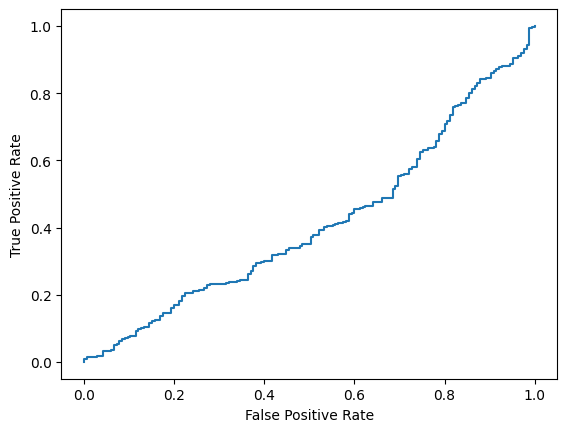

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Polynomial Kernel
model = SVC(gamma='auto', kernel='poly', probability=True).fit(X_train, y_train)
model.score(X_test,y_test)

0.6555323590814196

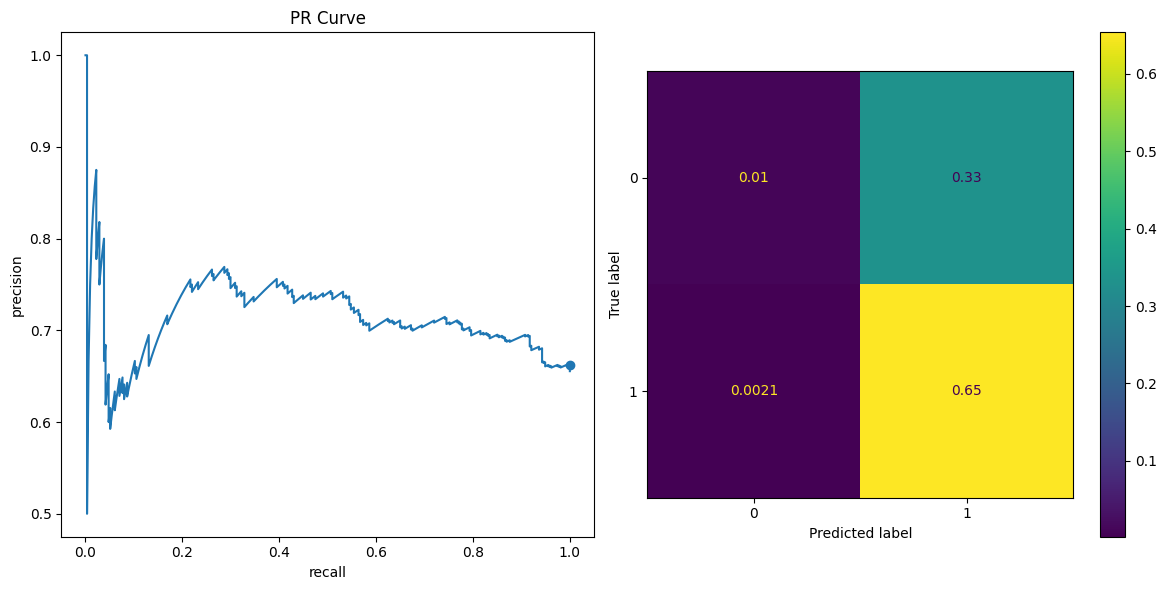

              precision    recall  f1-score   support

           0       0.83      0.03      0.06       165
           1       0.66      1.00      0.80       314

    accuracy                           0.66       479
   macro avg       0.75      0.51      0.43       479
weighted avg       0.72      0.66      0.54       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

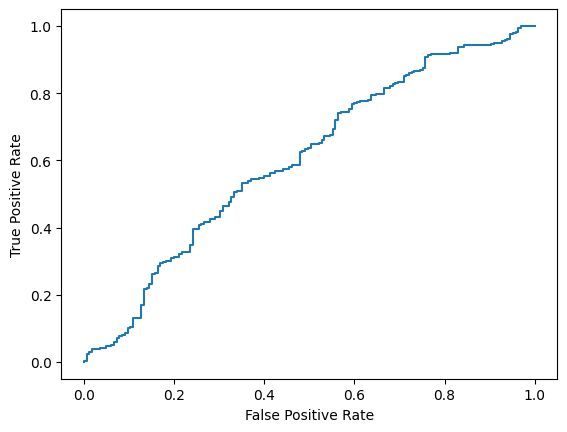

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# RBF Kernel
model = SVC(gamma='auto', kernel='rbf', probability=True).fit(X_train, y_train)
model.score(X_test,y_test)

0.6555323590814196

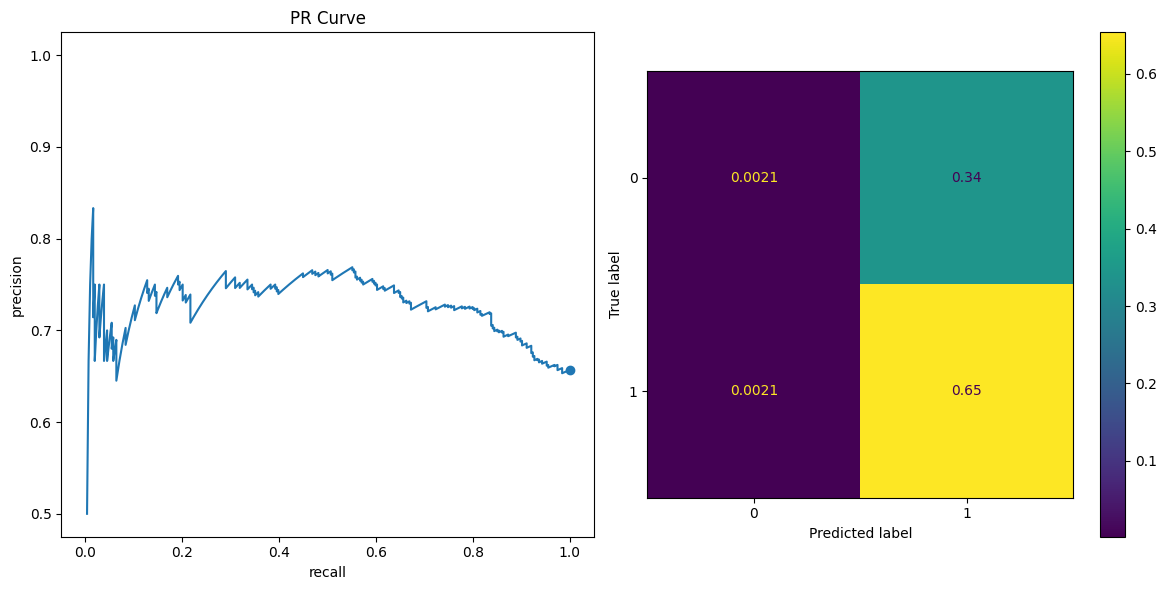

              precision    recall  f1-score   support

           0       0.50      0.01      0.01       165
           1       0.66      1.00      0.79       314

    accuracy                           0.66       479
   macro avg       0.58      0.50      0.40       479
weighted avg       0.60      0.66      0.52       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

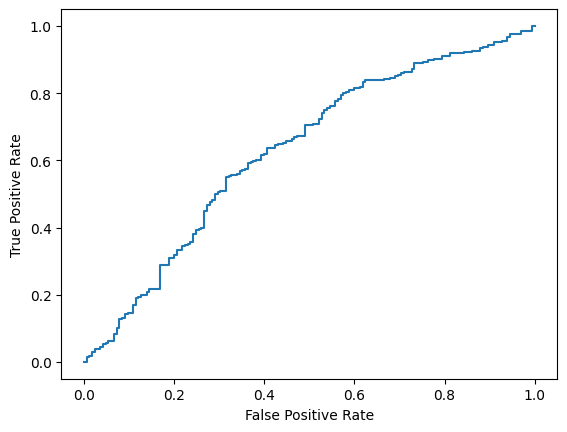

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Sigmoid Kernel
model = SVC(gamma='auto', kernel='sigmoid', probability=True).fit(X_train, y_train)
model.score(X_test,y_test)

0.6555323590814196

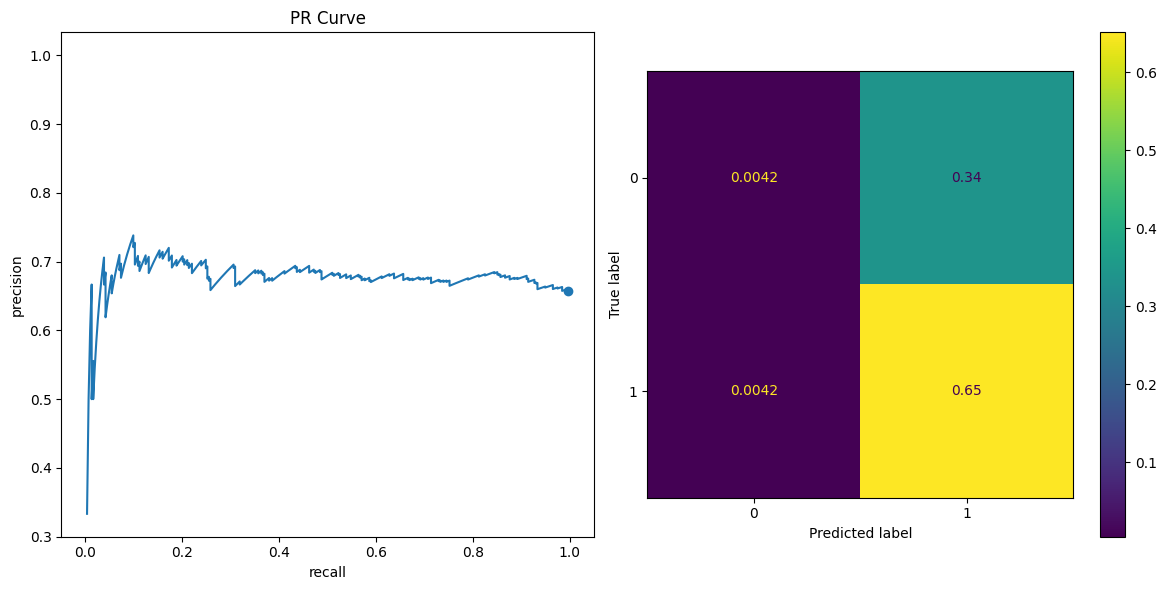

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       165
           1       0.66      0.99      0.79       314

    accuracy                           0.66       479
   macro avg       0.58      0.50      0.41       479
weighted avg       0.60      0.66      0.53       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

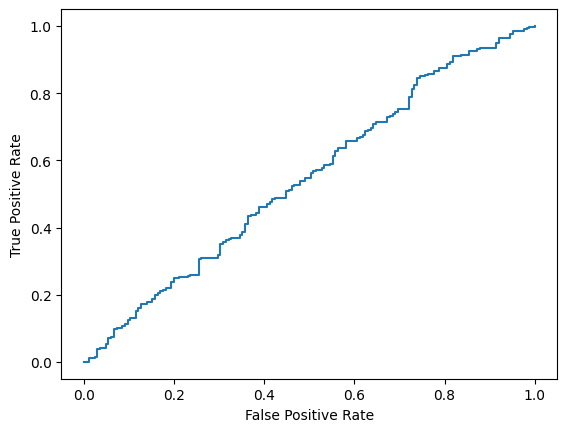

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMClassifier().fit(X_train, y_train)
model.score(X_test,y_test)

0.7620041753653445

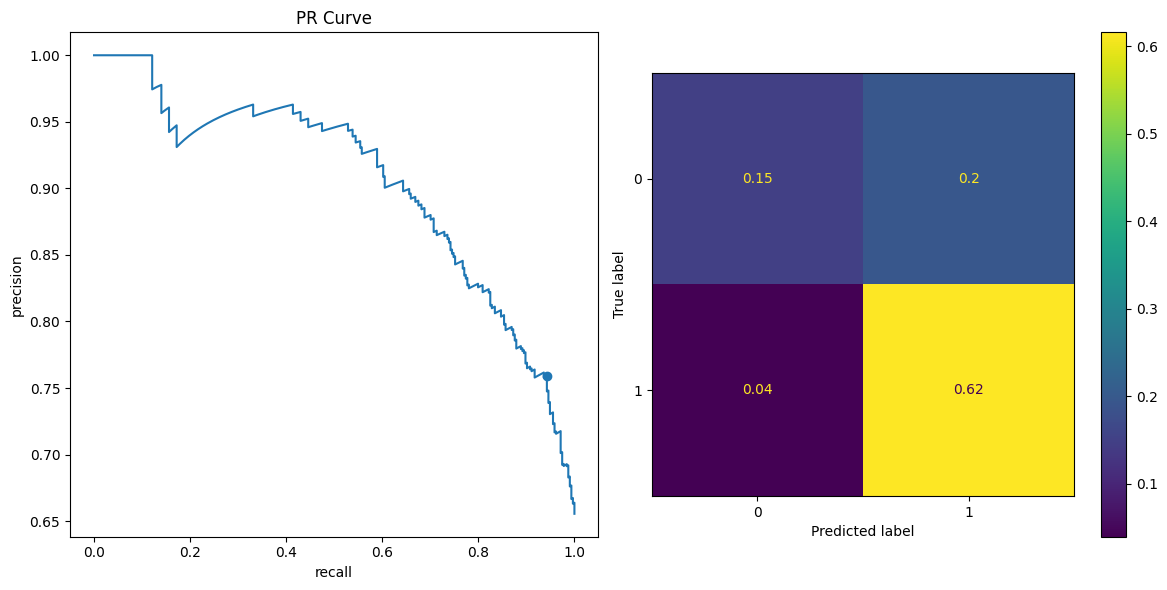

              precision    recall  f1-score   support

           0       0.79      0.43      0.56       165
           1       0.76      0.94      0.84       314

    accuracy                           0.76       479
   macro avg       0.77      0.68      0.70       479
weighted avg       0.77      0.76      0.74       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

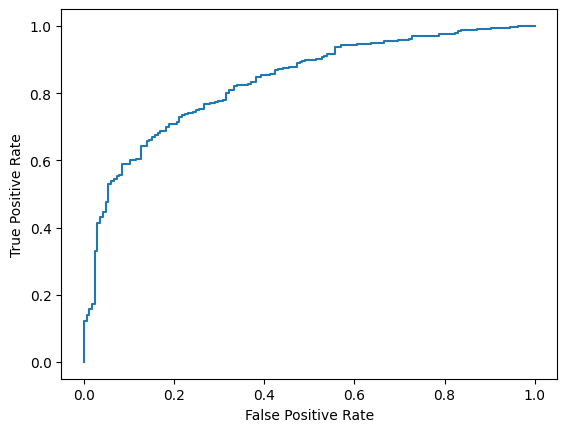

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

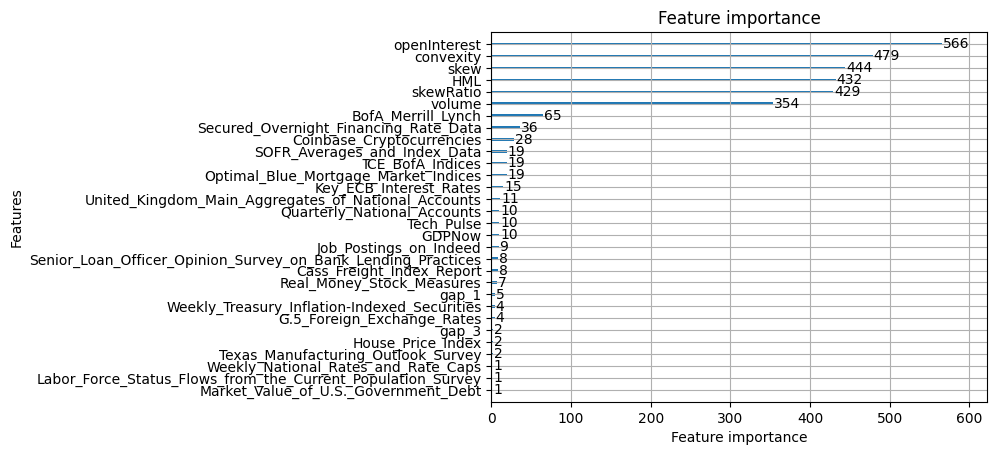

In [ ]:
lgb.plot_importance(model)

Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
model = AdaBoostClassifier(learning_rate=1.0, n_estimators=500).fit(X_train, y_train)
model.score(X_test, y_test)

0.6931106471816284

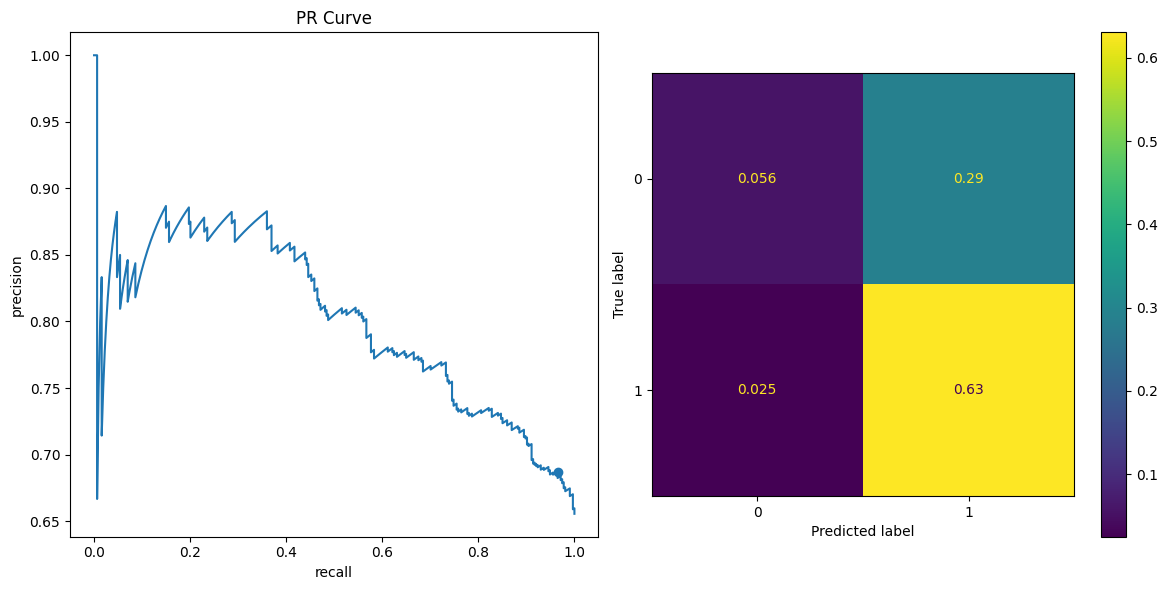

              precision    recall  f1-score   support

           0       0.69      0.16      0.26       165
           1       0.69      0.96      0.80       314

    accuracy                           0.69       479
   macro avg       0.69      0.56      0.53       479
weighted avg       0.69      0.69      0.62       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

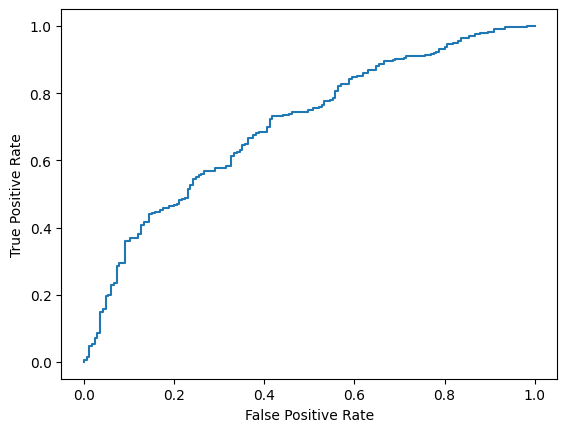

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Gradient Boost



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier(n_estimators=20, learning_rate=1.0, max_features=2, max_depth=2, random_state=0).fit(X_train, y_train)
model.score(X_test, y_test)

0.6826722338204593

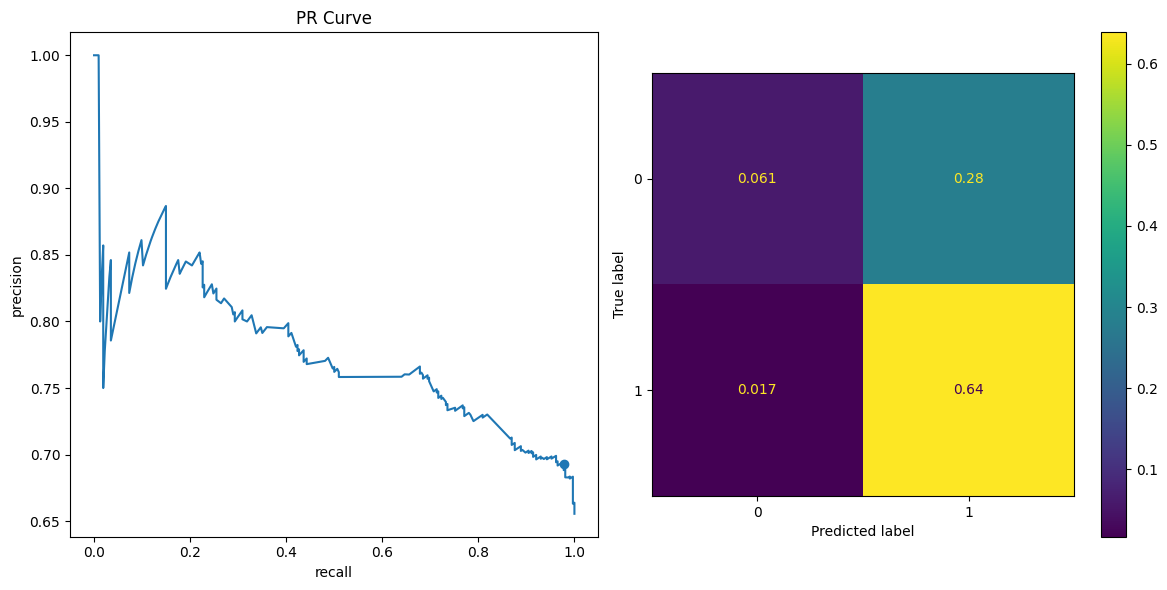

              precision    recall  f1-score   support

           0       0.78      0.18      0.29       165
           1       0.69      0.97      0.81       314

    accuracy                           0.70       479
   macro avg       0.74      0.58      0.55       479
weighted avg       0.72      0.70      0.63       479



In [ ]:
y_ = model.predict_proba(X_test)
precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test, tround(y_[:,1],t)))

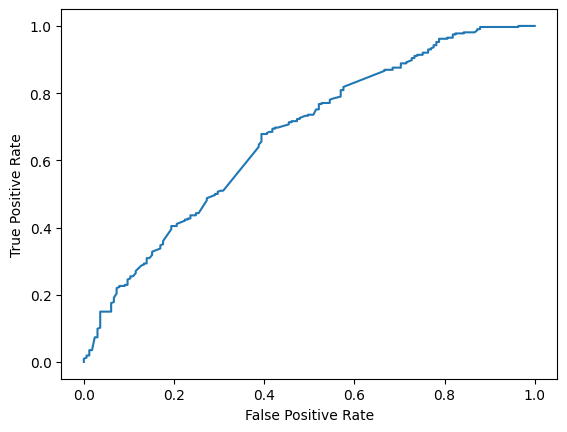

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_[::,1])
auc = metrics.roc_curve(y_test, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [ ]:
# XGBoost

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': np.arange(2, 10, 1),
        'n_estimators': np.arange(100, 1000, 50),
        'learning_rate': np.arange(0.01, 0.1, 0.01)
        }

In [ ]:
xgb_ = xgb.XGBClassifier(objective='binary:logistic', silent=True, nthread=4)

In [ ]:
grid_search = GridSearchCV(estimator=xgb_,
                           param_grid=params,
                           scoring='accuracy',
                           refit='recall',
                           n_jobs=-1,
                           cv=rkf,
                           verbose=0)

In [ ]:
#grid_search.fit(X_train, y_train)

In [ ]:
#grid_search.best_estimator_

In [ ]:
#model = grid_search.best_estimator_.fit(X_train, y_train)
#model.score(X_test, y_test)

In [ ]:
# y_ = model.predict_proba(X_test)
# precisions,recalls,thresholds = precision_recall_curve(y_test, y_[:,1])

# f_argmax = np.nanargmax(fscore(precisions, recalls))
# t = thresholds[f_argmax]
# p = precisions[f_argmax]
# r = recalls[f_argmax]

# fig,axes = plt.subplots(1, 2, figsize=(12,6))

# ax = axes[0]
# ax.plot(recalls, precisions)
# ax.set_xlabel('recall')
# ax.set_ylabel('precision')
# ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
# ax.set_title('PR Curve')

# ax = axes[1]
# ConfusionMatrixDisplay(confusion_matrix(y_test, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

# fig.tight_layout()
# plt.show()

# print(classification_report(y_test, tround(y_[:,1],t)))

In [ ]:
#xgb.plot_importance(model)

# Deep Learning

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(X_train.shape[-1],)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 8)                 408       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 50, batch_size = 128)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


15/15 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.6742
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accurac

In [ ]:
score = model.evaluate(X_test, y_test)
print(score)

15/15 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.6555


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


[0.0, 0.6555323600769043]


Feature Importance

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train1,y_train1)
model.score(X_test1,y_test1)

0.7390396659707724

In [ ]:
X4

volume      skew  convexity       HML  \
0     0.310414  0.000104     1.0661  0.021412   
1     0.211286 -0.000074     1.0532  0.013667   
2     0.185492  0.000137     1.0597  0.012750   
3     0.154063  0.000364     1.0423  0.011282   
4     0.283246  0.000290     1.0564  0.017809   
...        ...       ...        ...       ...   
2389  0.299119  0.000463     1.1035  0.015068   
2390  0.228092  0.000519     1.1061  0.010163   
2391  0.385401  0.000650     1.1193  0.026045   
2392  0.293730  0.000166     1.1029  0.018856   
2393  0.267449  0.000197     1.1158  0.013770   

      Optimal Blue Mortgage Market Indices  Penn World Table 10.0  \
0                                      0.0                    0.0   
1                                      0.0                    0.0   
2                                      0.0                    0.0   
3                                      0.0                    0.0   
4                                      0.0                    0.0   
...                                    ...                    ...   
2389                                   1.0                    0.0   
2390                                   1.0                    0.0   
2391                                   1.0                    0.0   
2392                                   1.0                    0.0   
2393                                   1.0                    0.0   

      ICE BofA Indices  Survey of Business Uncertainty  \
0                  0.0                             0.0   
1                  0.0                             0.0   
2                  0.0                             0.0   
3                  0.0                             0.0   
4                  0.0                             0.0   
...                ...                             ...   
2389               1.0                             1.0   
2390               1.0                             0.0   
2391               1.0                             0.0   
2392               1.0                             0.0   
2393               1.0                             0.0   

      Monthly State Retail Sales  Key ECB Interest Rates  ...  \
0                            0.0                     0.0  ...   
1                            0.0                     0.0  ...   
2                            0.0                     0.0  ...   
3                            0.0                     0.0  ...   
4                            0.0                     0.0  ...   
...                          ...                     ...  ...   
2389                         0.0                     1.0  ...   
2390                         1.0                     1.0  ...   
2391                         0.0                     1.0  ...   
2392                         0.0                     1.0  ...   
2393                         0.0                     1.0  ...   

      Quarterly National Accounts  Job Postings on Indeed  \
0                             1.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
...                           ...                     ...   
2389                          0.0                     0.0   
2390                          0.0                     0.0   
2391                          0.0                     0.0   
2392                          1.0                     0.0   
2393                          0.0                     0.0   

      New Patent Assignments  Construction Spending  Penn World Table 10.01  \
0                        0.0                    0.0                     0.0   
1                        0.0                    0.0                     0.0   
2                        0.0                    0.0                     0.0   
3                        0.0                    0.0            

### openInterest/skewRatio



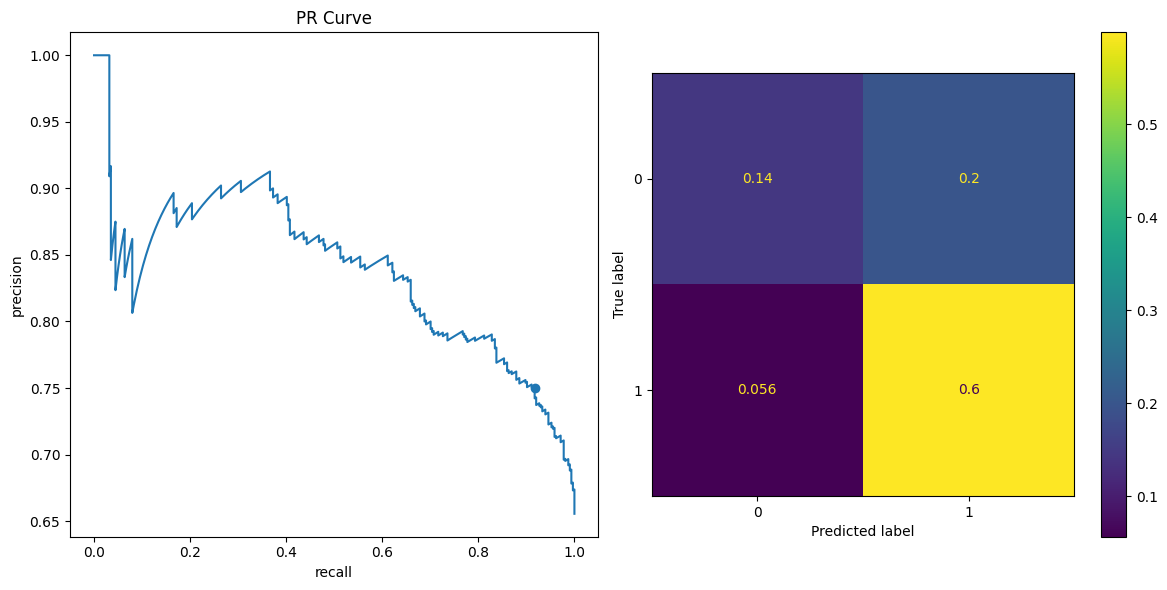

              precision    recall  f1-score   support

           0       0.72      0.42      0.53       165
           1       0.75      0.91      0.82       314

    accuracy                           0.74       479
   macro avg       0.73      0.67      0.68       479
weighted avg       0.74      0.74      0.72       479



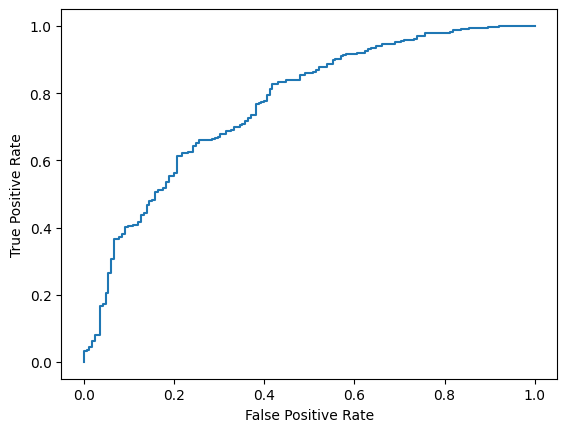

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

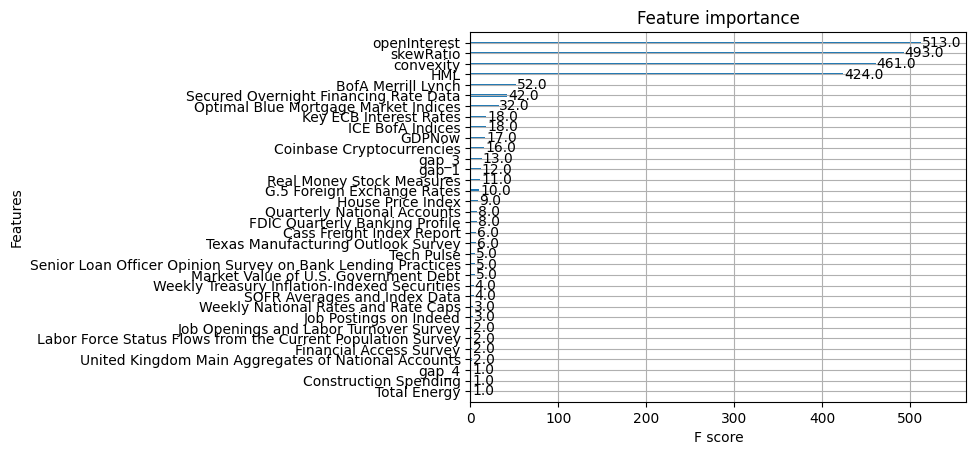

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train1, y_train1)
model.score(X_test1,y_test1)

y_ = model.predict_proba(X_test1)
precisions,recalls,thresholds = precision_recall_curve(y_test1, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test1, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test1, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test1,  y_[::,1])
auc = metrics.roc_curve(y_test1, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

xgb.plot_importance(model)

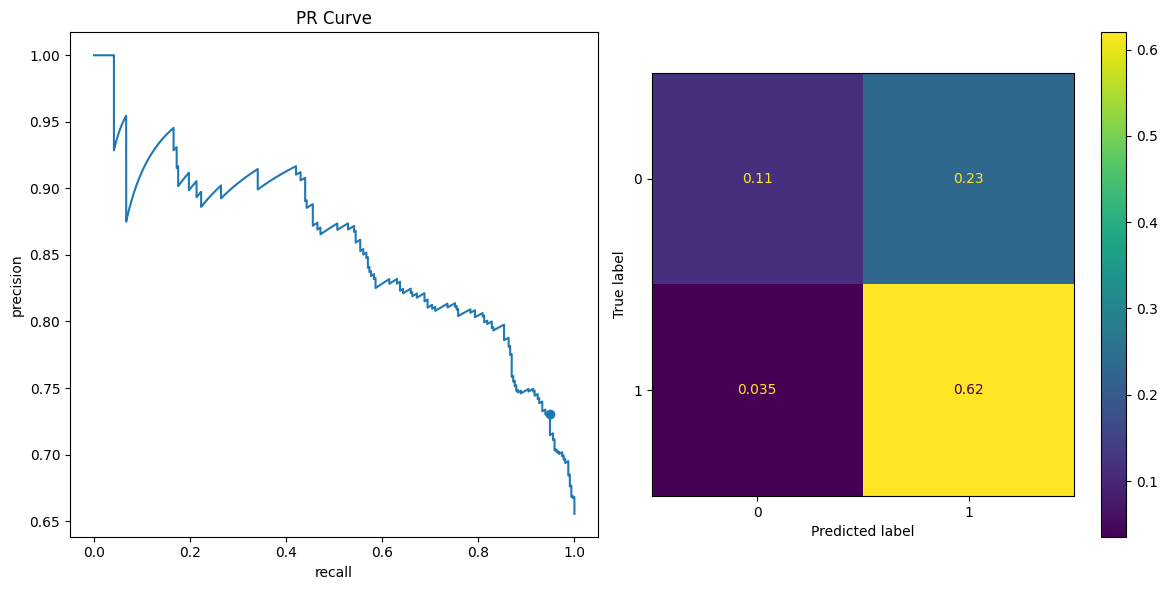

              precision    recall  f1-score   support

           0       0.76      0.33      0.46       165
           1       0.73      0.95      0.82       314

    accuracy                           0.73       479
   macro avg       0.75      0.64      0.64       479
weighted avg       0.74      0.73      0.70       479



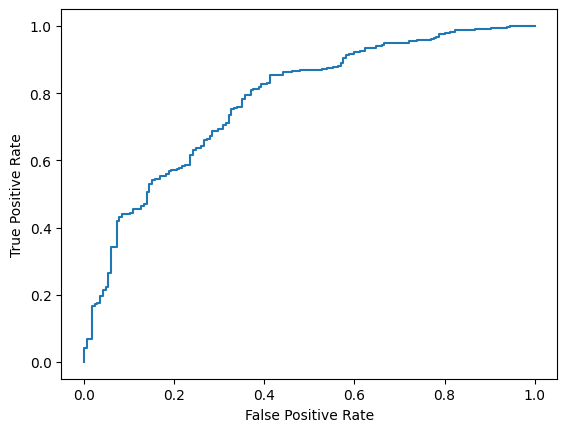

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

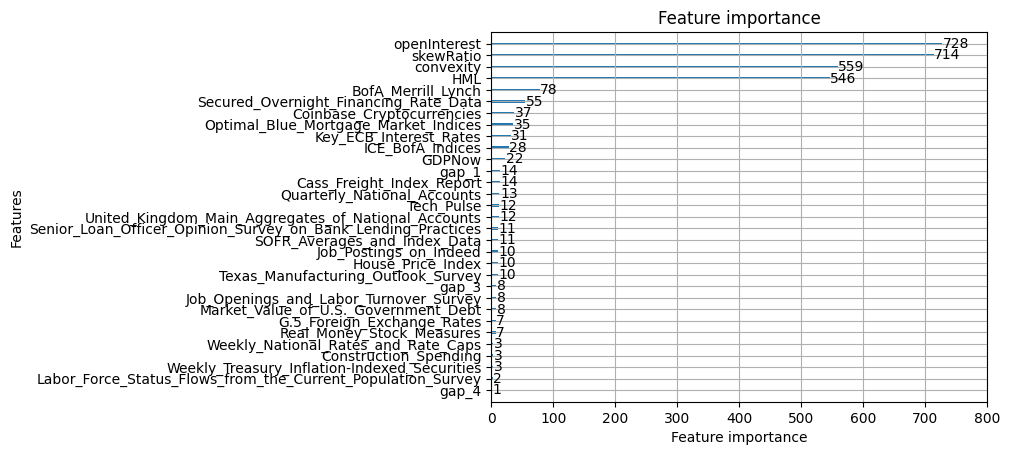

In [ ]:
model = lgb.LGBMClassifier().fit(X_train1, y_train1)
model.score(X_test1,y_test1)

y_ = model.predict_proba(X_test1)
precisions,recalls,thresholds = precision_recall_curve(y_test1, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test1, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test1, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test1,  y_[::,1])
auc = metrics.roc_curve(y_test1, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

lgb.plot_importance(model)

### openInterest/skew

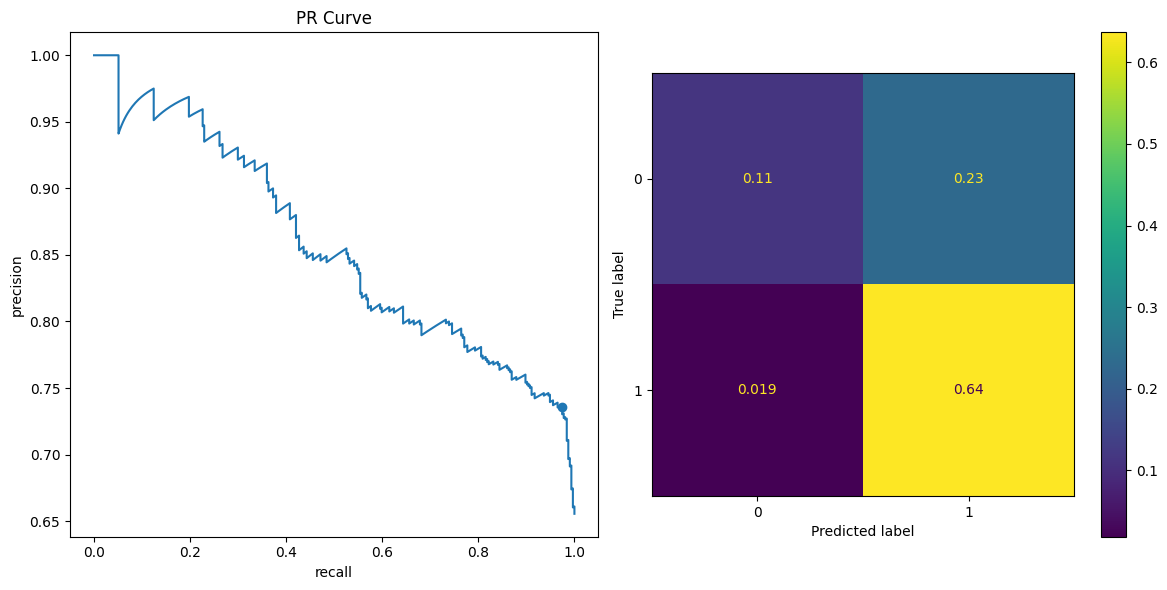

              precision    recall  f1-score   support

           0       0.86      0.33      0.48       165
           1       0.73      0.97      0.84       314

    accuracy                           0.75       479
   macro avg       0.80      0.65      0.66       479
weighted avg       0.78      0.75      0.71       479



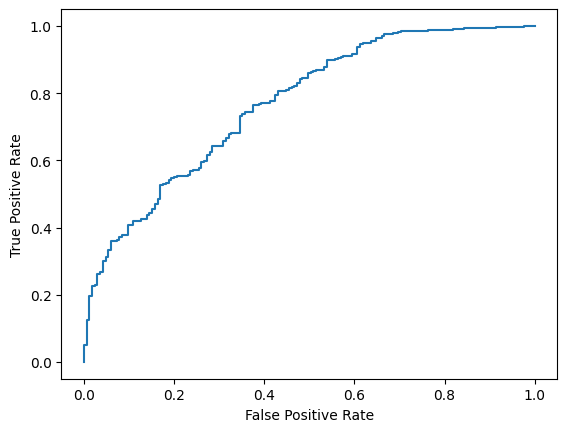

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

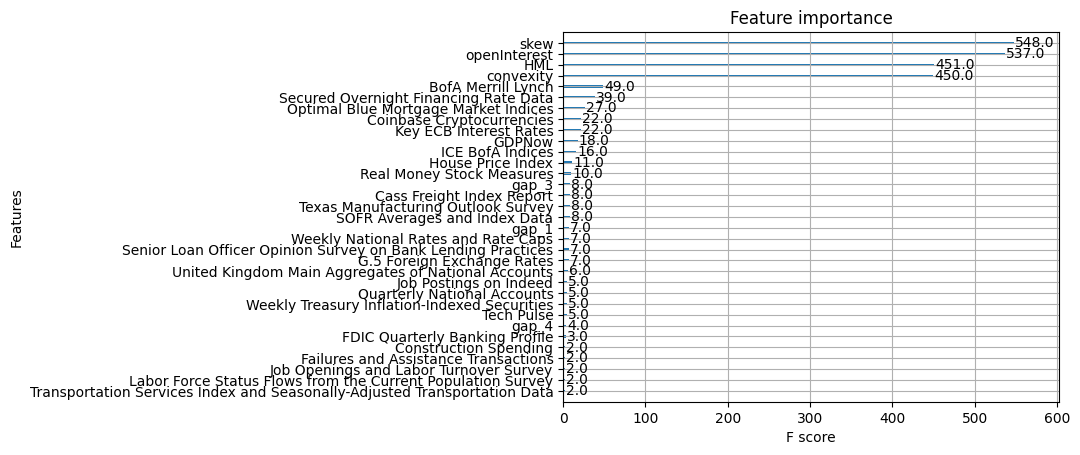

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train2, y_train2)
model.score(X_test2,y_test2)

y_ = model.predict_proba(X_test2)
precisions,recalls,thresholds = precision_recall_curve(y_test2, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test2, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test2, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test2,  y_[::,1])
auc = metrics.roc_curve(y_test2, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

xgb.plot_importance(model)

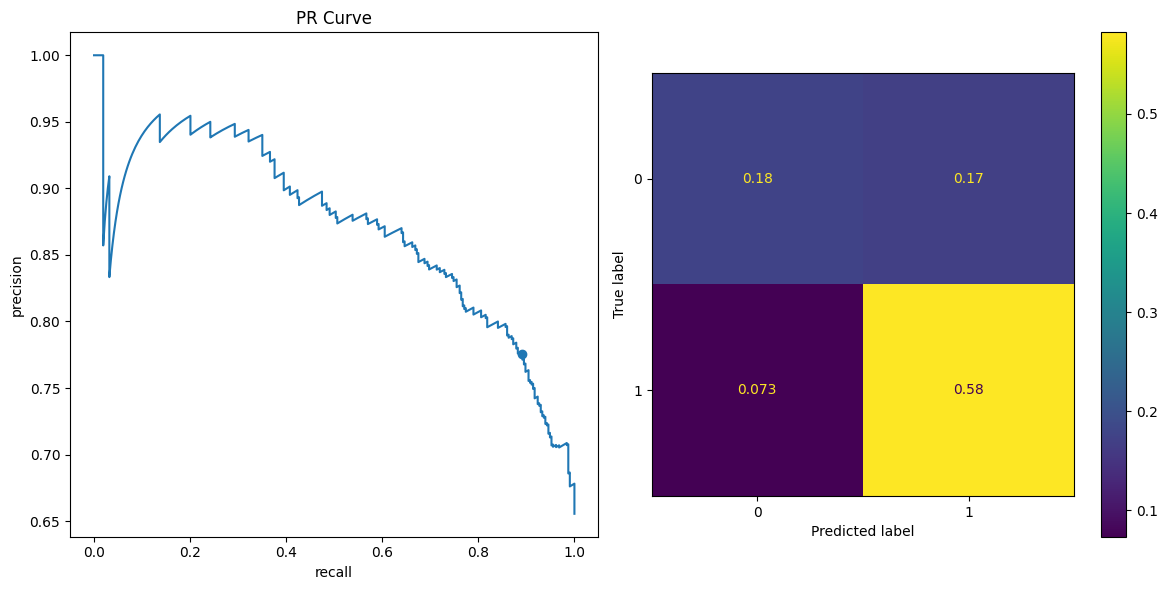

              precision    recall  f1-score   support

           0       0.71      0.51      0.59       165
           1       0.78      0.89      0.83       314

    accuracy                           0.76       479
   macro avg       0.74      0.70      0.71       479
weighted avg       0.75      0.76      0.75       479



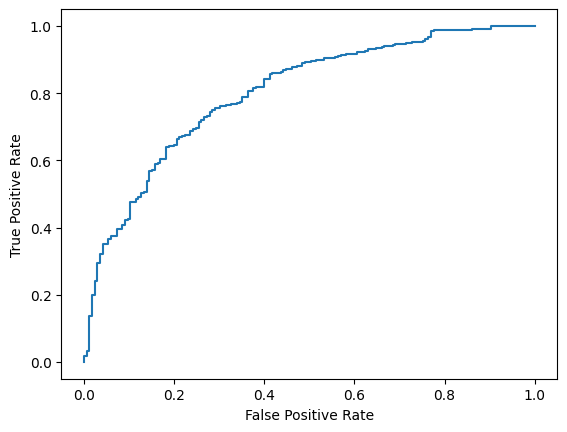

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

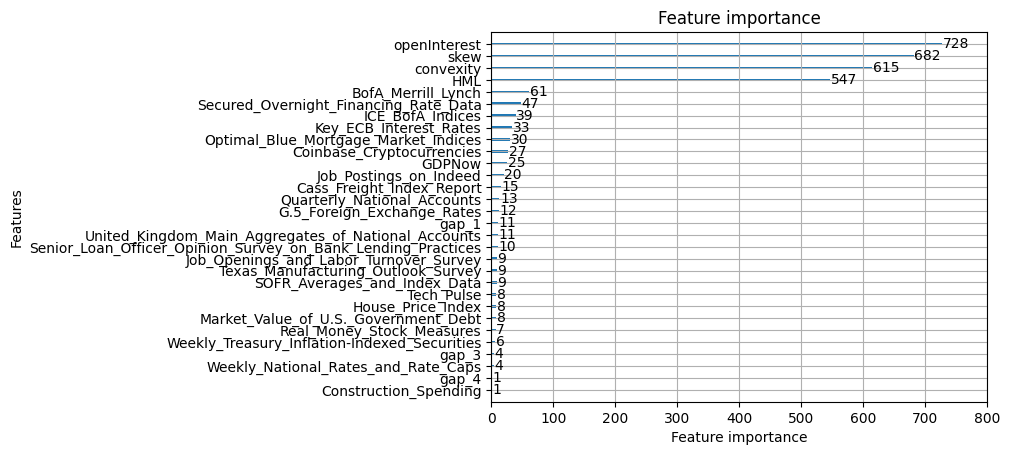

In [ ]:
model = lgb.LGBMClassifier().fit(X_train2, y_train2)
model.score(X_test2,y_test2)

y_ = model.predict_proba(X_test2)
precisions,recalls,thresholds = precision_recall_curve(y_test2, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test2, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test2, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test2,  y_[::,1])
auc = metrics.roc_curve(y_test2, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

lgb.plot_importance(model)

### volume/skewRatio

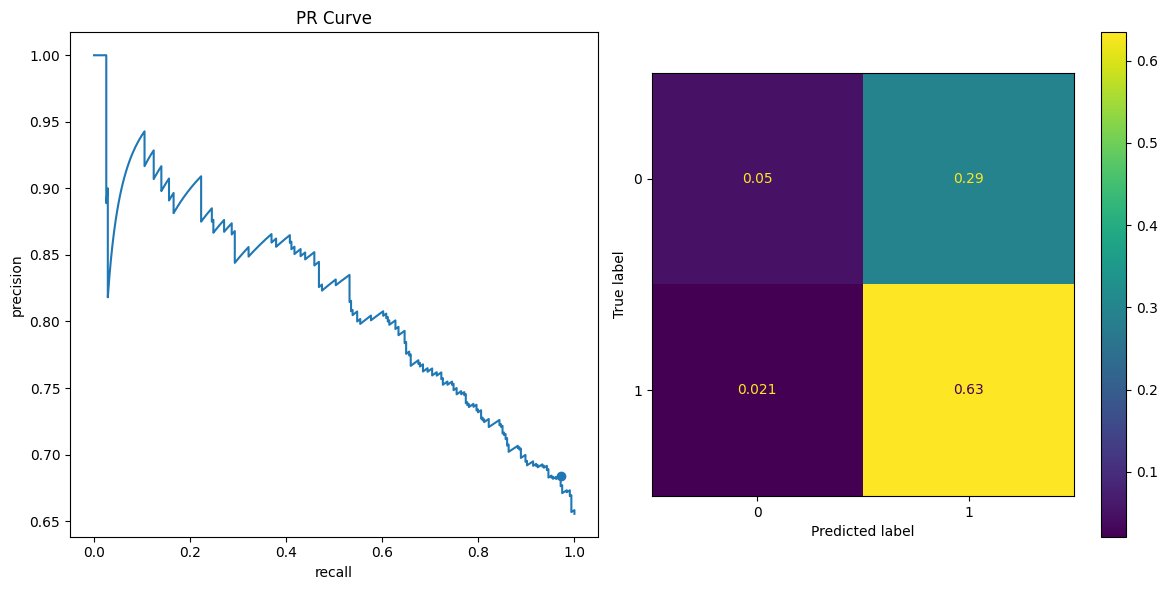

              precision    recall  f1-score   support

           0       0.71      0.15      0.24       165
           1       0.68      0.97      0.80       314

    accuracy                           0.68       479
   macro avg       0.69      0.56      0.52       479
weighted avg       0.69      0.68      0.61       479



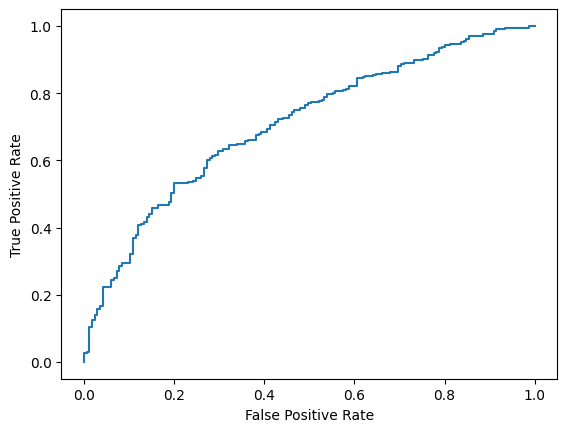

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

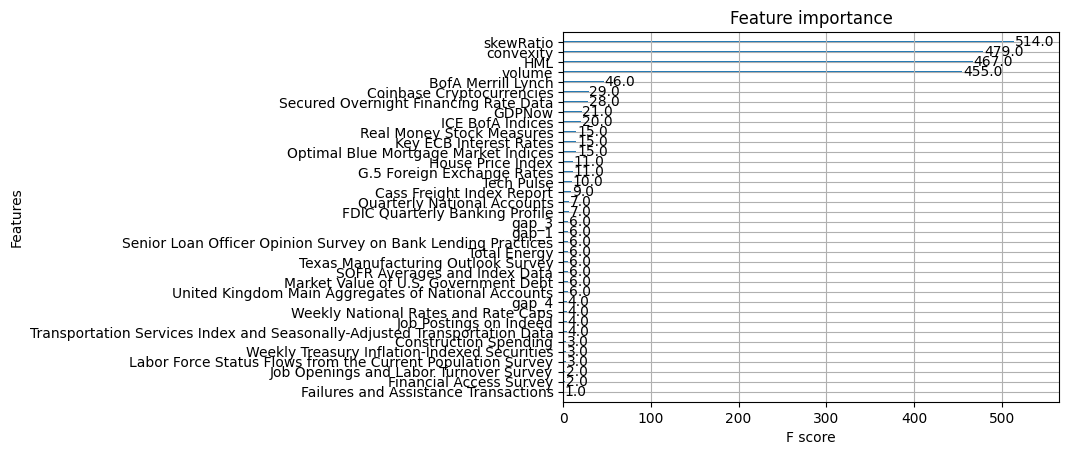

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train3, y_train3)
model.score(X_test3,y_test3)

y_ = model.predict_proba(X_test3)
precisions,recalls,thresholds = precision_recall_curve(y_test3, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test3, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test3, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test3,  y_[::,1])
auc = metrics.roc_curve(y_test3, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

xgb.plot_importance(model)

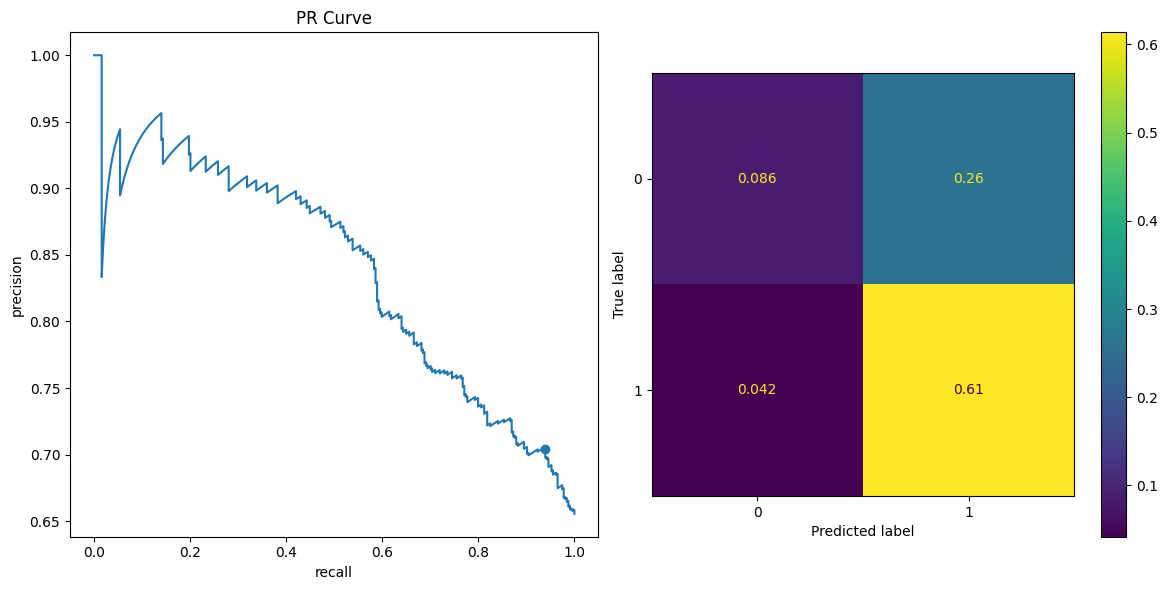

              precision    recall  f1-score   support

           0       0.67      0.25      0.36       165
           1       0.70      0.94      0.80       314

    accuracy                           0.70       479
   macro avg       0.69      0.59      0.58       479
weighted avg       0.69      0.70      0.65       479



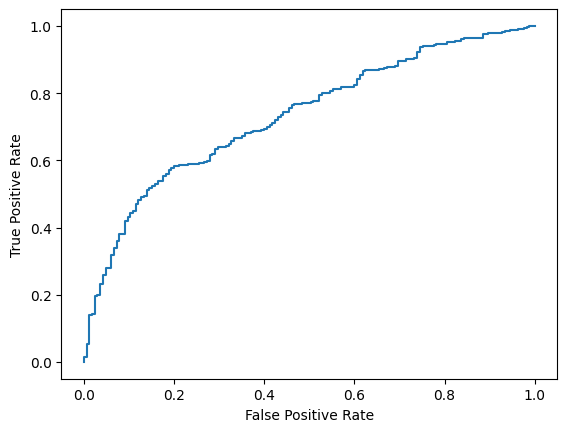

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

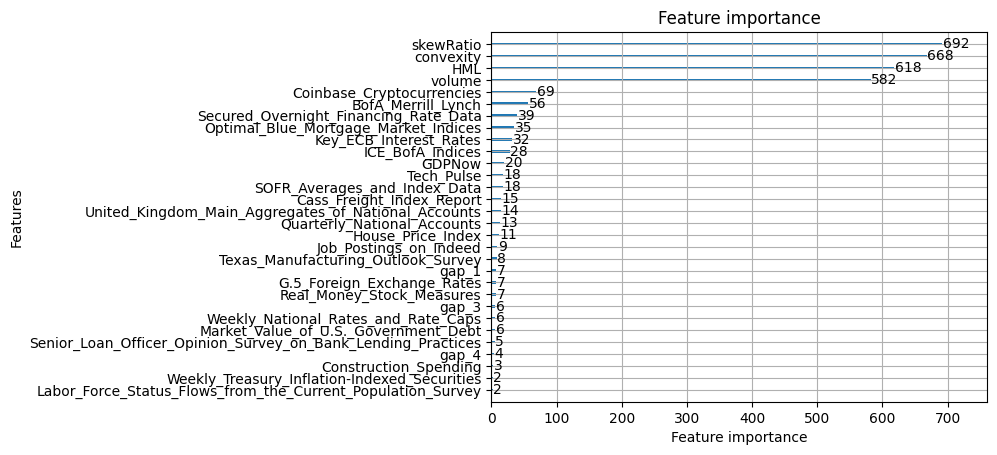

In [ ]:
model = lgb.LGBMClassifier().fit(X_train3, y_train3)
model.score(X_test3,y_test3)

y_ = model.predict_proba(X_test3)
precisions,recalls,thresholds = precision_recall_curve(y_test3, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test3, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test3, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test3,  y_[::,1])
auc = metrics.roc_curve(y_test3, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

lgb.plot_importance(model)

### volume/skew

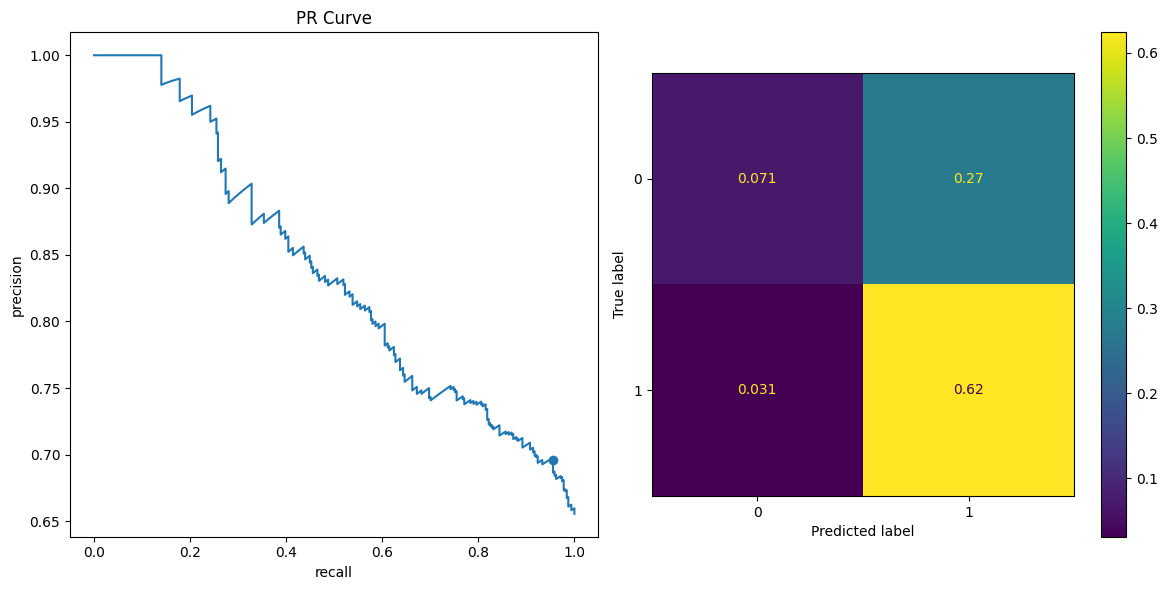

              precision    recall  f1-score   support

           0       0.69      0.21      0.32       165
           1       0.70      0.95      0.80       314

    accuracy                           0.70       479
   macro avg       0.69      0.58      0.56       479
weighted avg       0.69      0.70      0.64       479



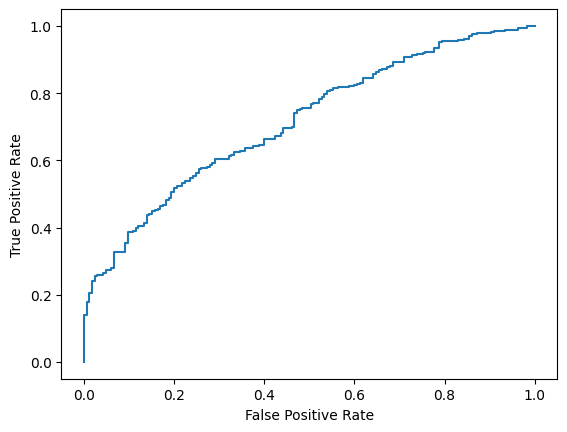

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

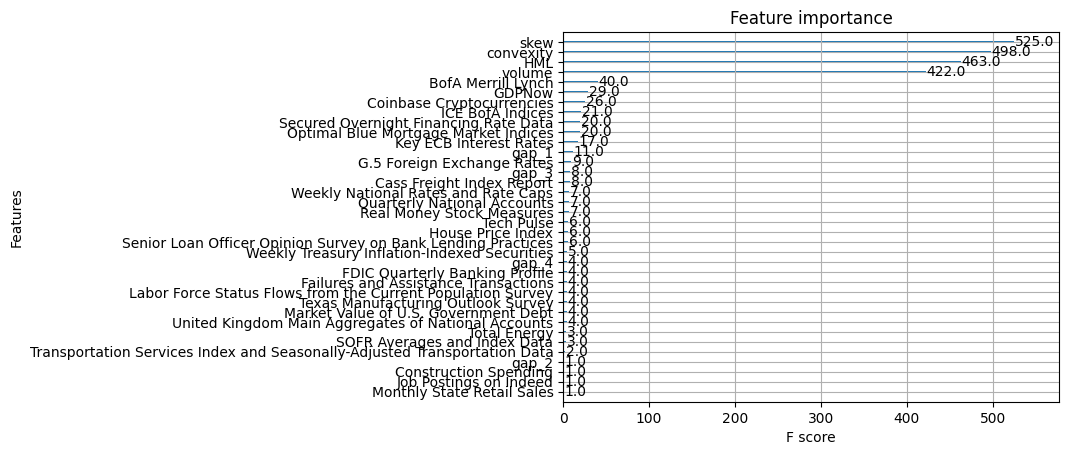

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train4, y_train4)
model.score(X_test4,y_test4)

y_ = model.predict_proba(X_test4)
precisions,recalls,thresholds = precision_recall_curve(y_test4, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test4, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test4, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test4,  y_[::,1])
auc = metrics.roc_curve(y_test4, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

xgb.plot_importance(model)

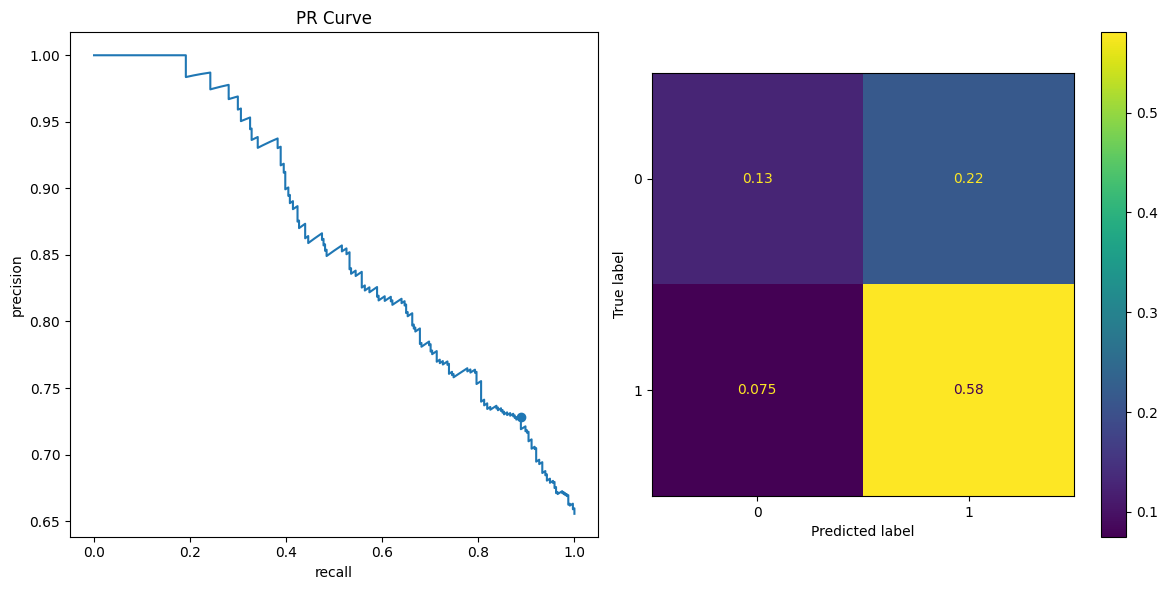

              precision    recall  f1-score   support

           0       0.63      0.37      0.47       165
           1       0.73      0.89      0.80       314

    accuracy                           0.71       479
   macro avg       0.68      0.63      0.63       479
weighted avg       0.69      0.71      0.68       479



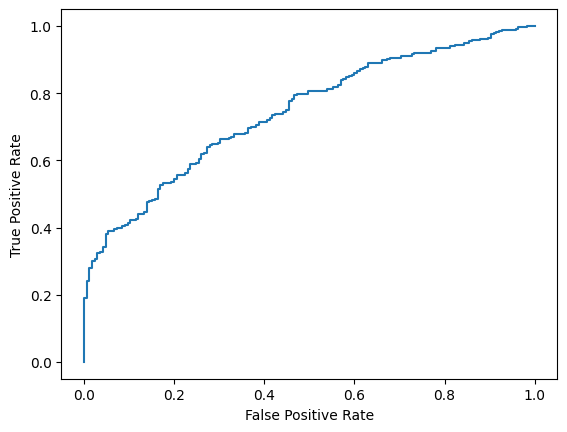

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

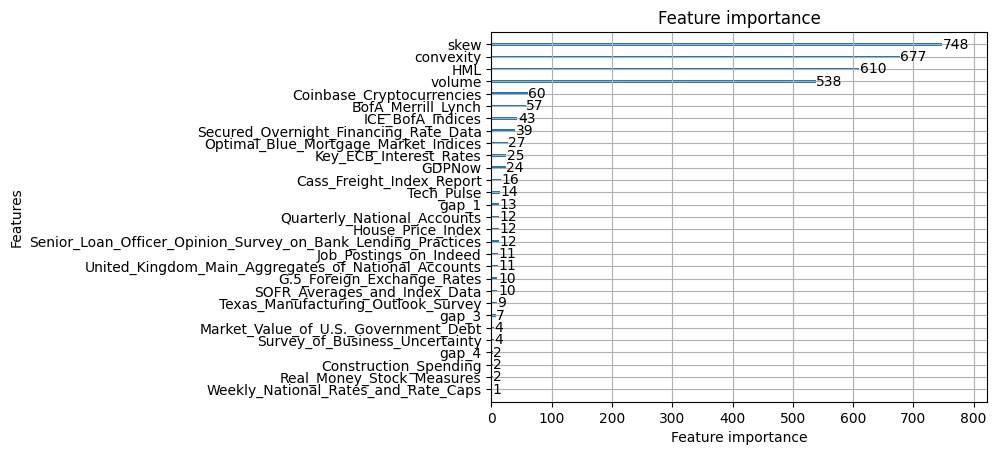

In [ ]:
model = lgb.LGBMClassifier().fit(X_train4, y_train4)
model.score(X_test4,y_test4)

y_ = model.predict_proba(X_test4)
precisions,recalls,thresholds = precision_recall_curve(y_test4, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test4, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test4, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test4,  y_[::,1])
auc = metrics.roc_curve(y_test4, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

lgb.plot_importance(model)

Imbalanced Data

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smt = SMOTE(sampling_strategy='minority', random_state=43, n_jobs=-1)
X_balanced, y_balanced = smt.fit_resample(X, y)
X1_balanced = X_balanced.drop(columns=['volume', 'skew'])
X2_balanced = X_balanced.drop(columns=['volume', 'skewRatio'])
X3_balanced = X_balanced.drop(columns=['openInterest', 'skew'])
X4_balanced = X_balanced.drop(columns=['openInterest', 'skewRatio'])

X_train1_balanced, X_test1_balanced, y_train1_balanced, y_test1_balanced = train_test_split(X1_balanced, y_balanced, test_size=0.2, random_state=42)
X_train2_balanced, X_test2_balanced, y_train2_balanced, y_test2_balanced = train_test_split(X2_balanced, y_balanced, test_size=0.2, random_state=42)
X_train3_balanced, X_test3_balanced, y_train3_balanced, y_test3_balanced = train_test_split(X3_balanced, y_balanced, test_size=0.2, random_state=42)
X_train4_balanced, X_test4_balanced, y_train4_balanced, y_test4_balanced = train_test_split(X4_balanced, y_balanced, test_size=0.2, random_state=42)

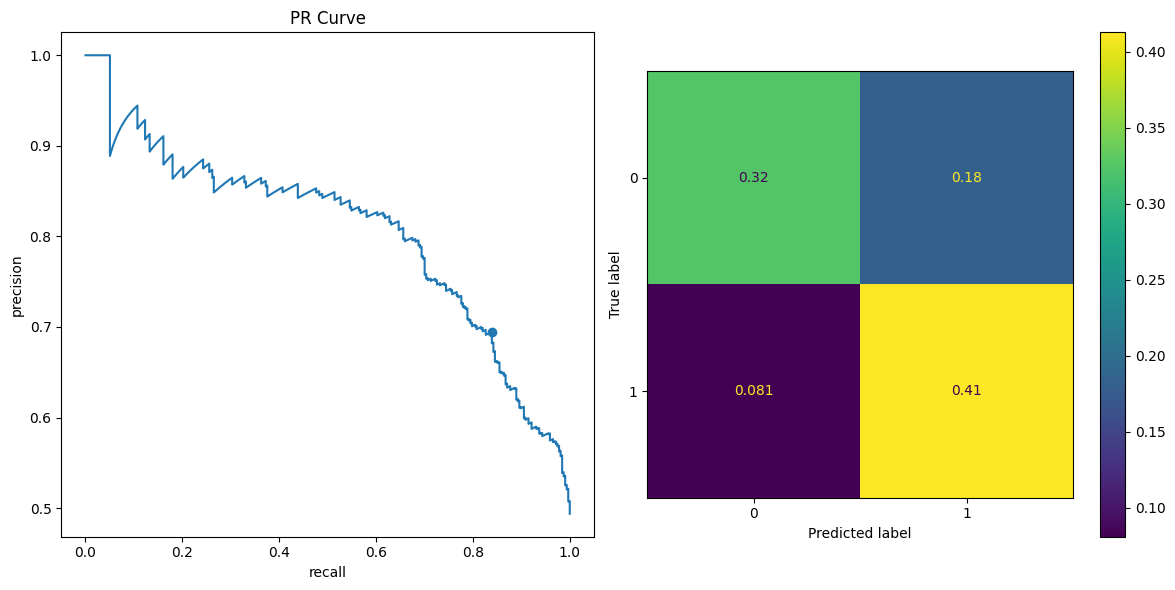

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       325
           1       0.69      0.84      0.76       317

    accuracy                           0.74       642
   macro avg       0.75      0.74      0.73       642
weighted avg       0.75      0.74      0.73       642



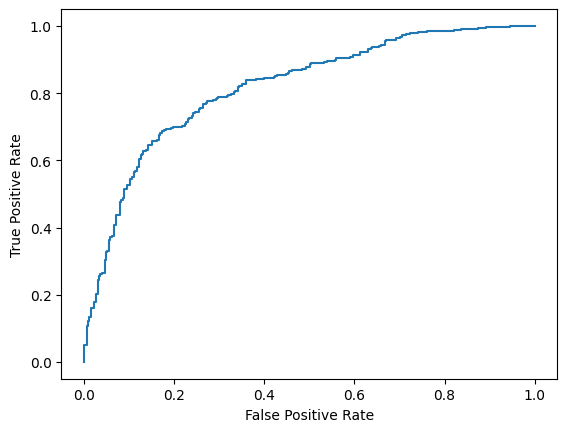

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

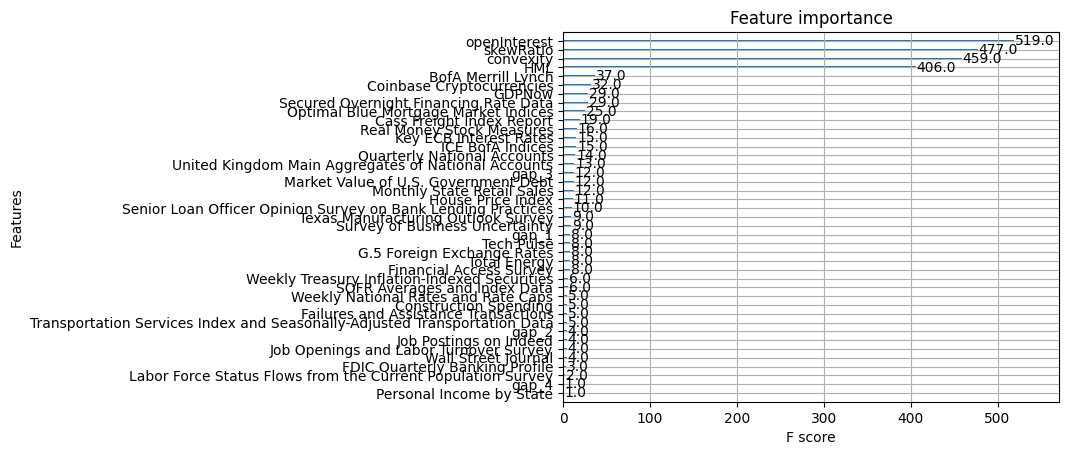

In [ ]:
model = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train1_balanced, y_train1_balanced)
model.score(X_test1_balanced,y_test1_balanced)

y_ = model.predict_proba(X_test1_balanced)
precisions,recalls,thresholds = precision_recall_curve(y_test1_balanced, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test1_balanced, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test1_balanced, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test1_balanced,  y_[::,1])
auc = metrics.roc_curve(y_test1_balanced, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

xgb.plot_importance(model)

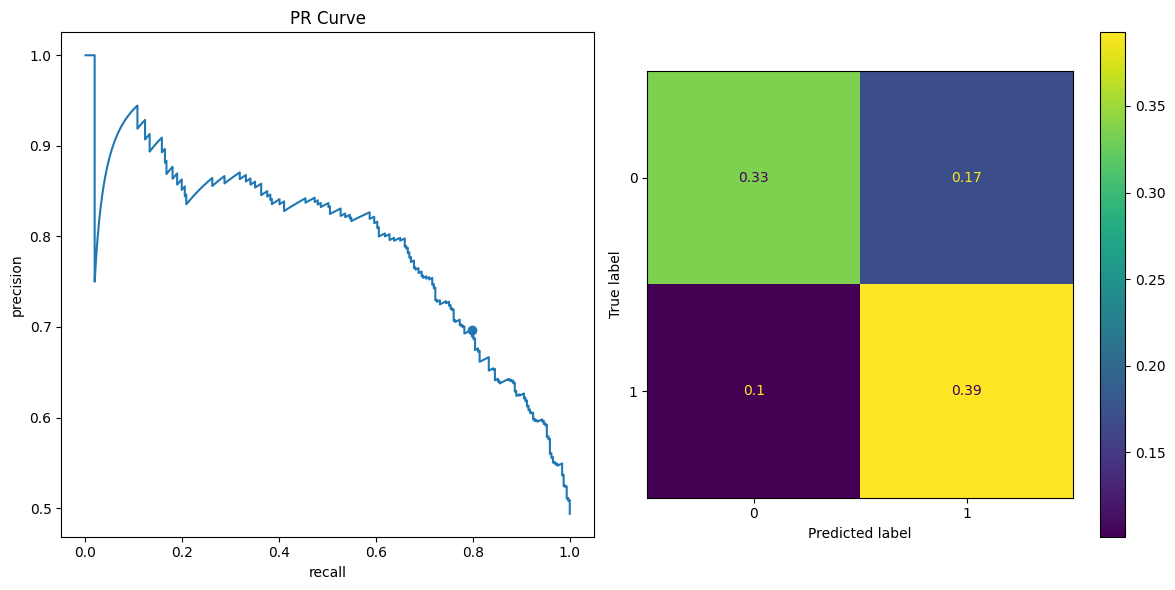

              precision    recall  f1-score   support

           0       0.77      0.66      0.71       325
           1       0.70      0.79      0.74       317

    accuracy                           0.73       642
   macro avg       0.73      0.73      0.73       642
weighted avg       0.73      0.73      0.73       642



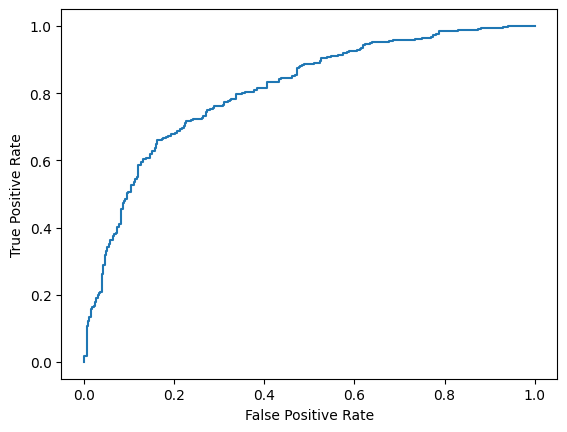

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

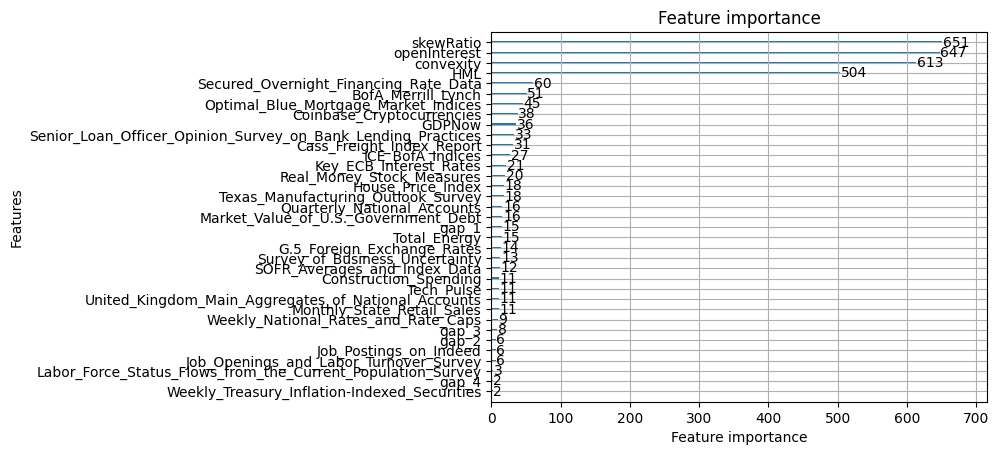

In [ ]:
model = lgb.LGBMClassifier().fit(X_train1_balanced, y_train1_balanced)
model.score(X_test1_balanced,y_test1_balanced)

y_ = model.predict_proba(X_test1_balanced)
precisions,recalls,thresholds = precision_recall_curve(y_test1_balanced, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test1_balanced, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test1_balanced, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test1_balanced,  y_[::,1])
auc = metrics.roc_curve(y_test1_balanced, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

lgb.plot_importance(model)

## Shap

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
import shap

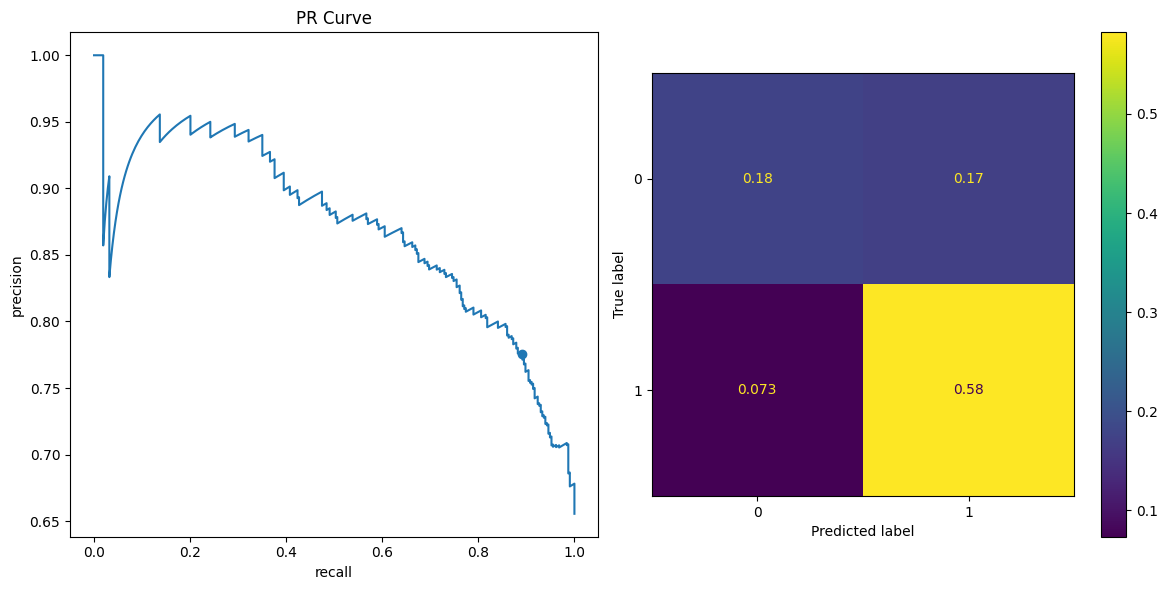

              precision    recall  f1-score   support

           0       0.71      0.51      0.59       165
           1       0.78      0.89      0.83       314

    accuracy                           0.76       479
   macro avg       0.74      0.70      0.71       479
weighted avg       0.75      0.76      0.75       479



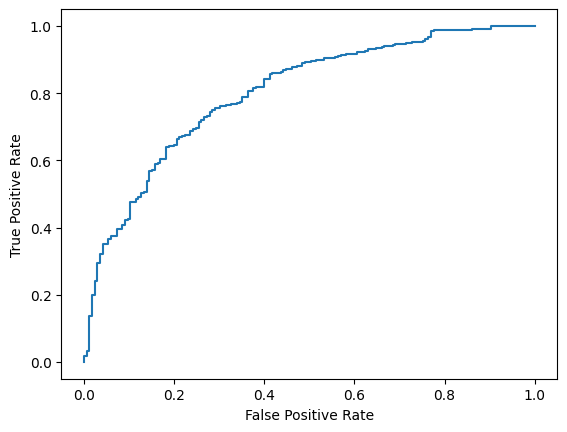

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

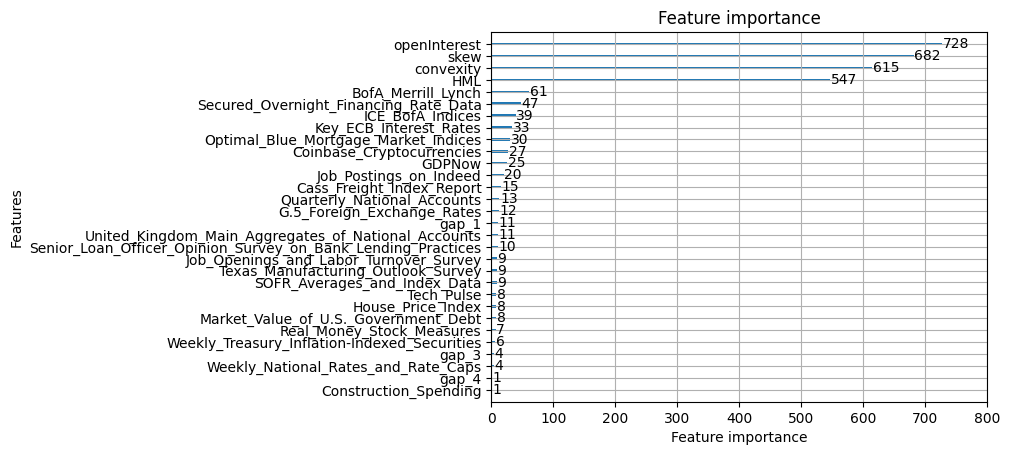

In [ ]:
model = lgb.LGBMClassifier().fit(X_train2, y_train2)
model.score(X_test2,y_test2)

y_ = model.predict_proba(X_test2)
precisions,recalls,thresholds = precision_recall_curve(y_test2, y_[:,1])

f_argmax = np.nanargmax(fscore(precisions, recalls))
t = thresholds[f_argmax]
p = precisions[f_argmax]
r = recalls[f_argmax]

fig,axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ax.plot(recalls, precisions)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.scatter(r, p, marker='o', label='F1-max ({:.3f}, {:.3f})'.format(r,p))
ax.set_title('PR Curve')

ax = axes[1]
ConfusionMatrixDisplay(confusion_matrix(y_test2, tround(y_[:,1],t), normalize='all')).plot(ax=ax)

fig.tight_layout()
plt.show()

print(classification_report(y_test2, tround(y_[:,1],t)))

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test2,  y_[::,1])
auc = metrics.roc_curve(y_test2, y_[::,1])
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

lgb.plot_importance(model)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


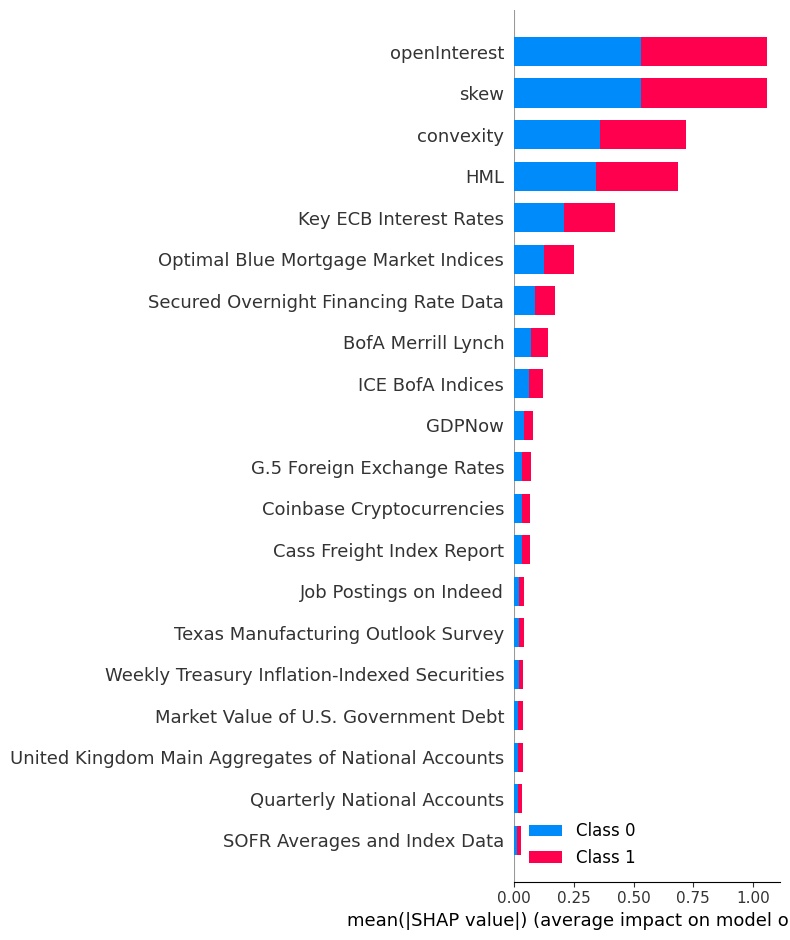

In [ ]:
#explainer = shap.TreeExplainer(model)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test2)
# visualize the first prediction's explanation
shap.summary_plot(shap_values, X_test2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


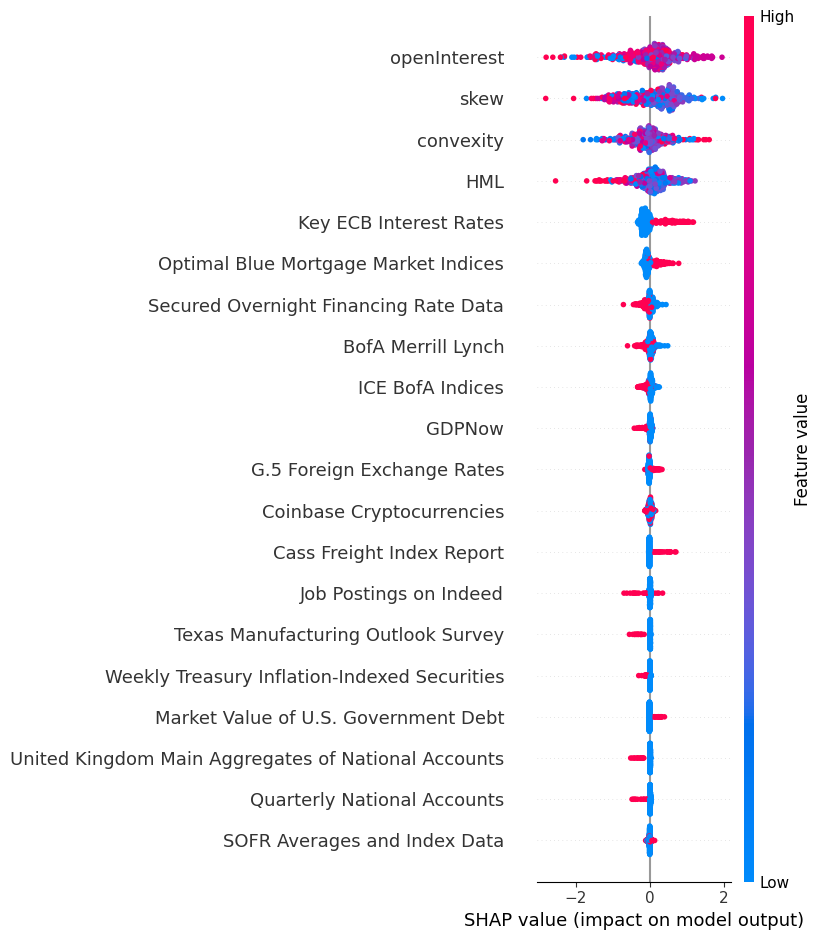

In [ ]:
shap.summary_plot(shap_values[1], X_test2)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:200,:], X_test2.iloc[:200,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][201:,:], X_test2.iloc[201:,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][100,:], X_test2.iloc[100,:])

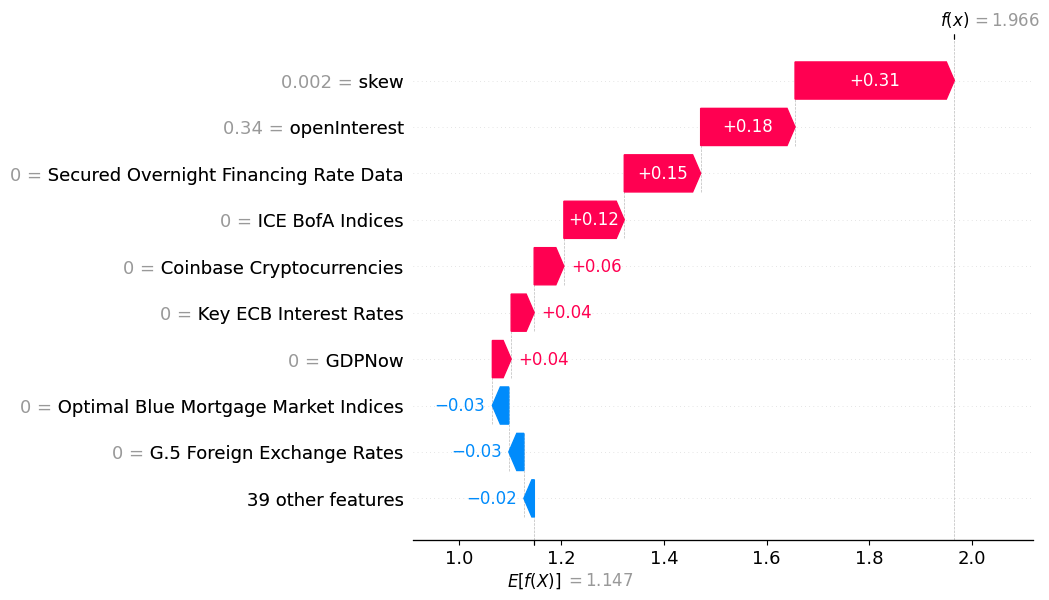

None

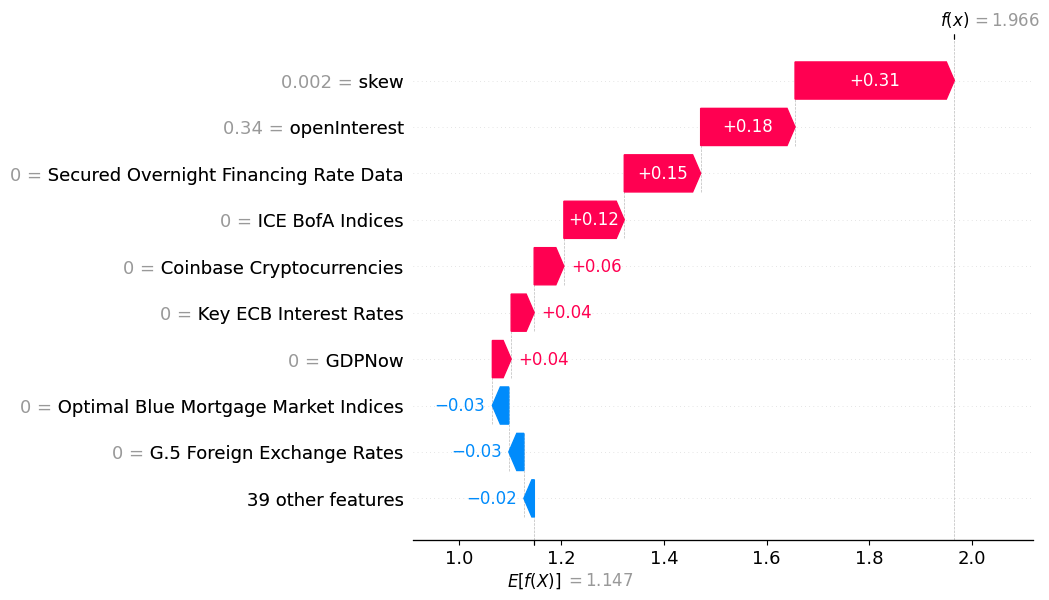

None

In [ ]:
for which_class in y.unique():
        display(
    shap.waterfall_plot(shap.Explanation(values=shap_values[1][420],
                                         base_values=explainer.expected_value[1],
                                         data=X_test2.iloc[420],  # added this line
                                         feature_names=X_test2.columns.tolist())
                       )
)

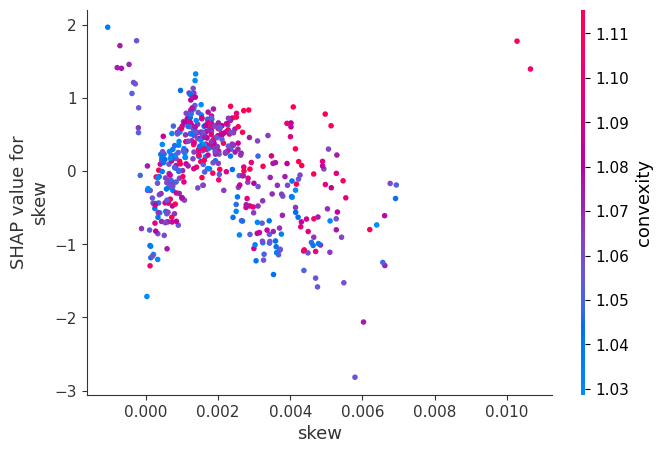

In [ ]:
shap.dependence_plot("skew", shap_values[1], X_test2, interaction_index="convexity")

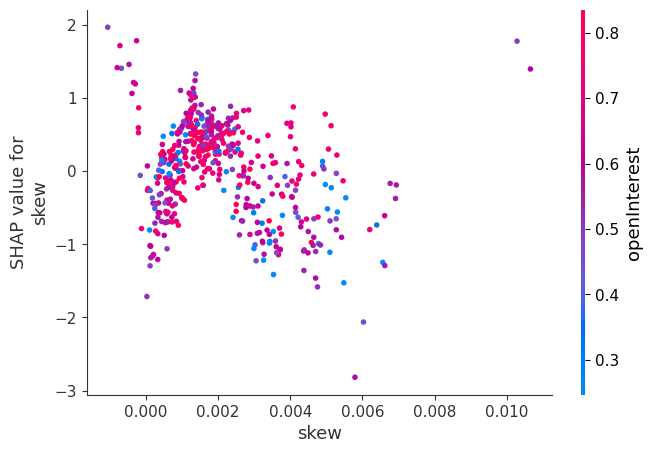

In [ ]:
shap.dependence_plot("skew", shap_values[1], X_test2, interaction_index="openInterest")

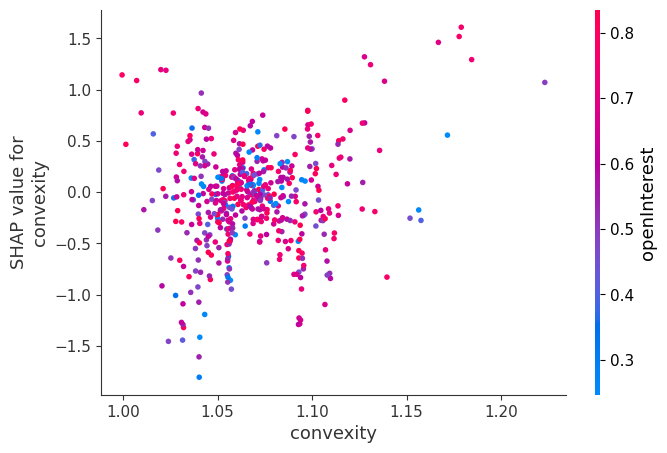

In [ ]:
shap.dependence_plot("convexity", shap_values[1], X_test2, interaction_index="openInterest")